! pip3 install pandas
! pip3 install numpy
! pip3 install matplotlib
! pip3 install seaborn
! pip3 install requests
! pip3 install -U scikit-learn
! pip3 install openpyxl

In [209]:

import pandas as pd

import io
import os
import numpy as np

import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import requests

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.cluster import SpectralClustering

from time import strftime


In [210]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rcParams['figure.figsize'] = [11.7, 8.27]

In [211]:
directory_path = os.getcwd()
if not os.path.exists(directory_path+'//Результаты'):
    os.makedirs('Результаты')

In [212]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [213]:
req = requests.get(bond_url).content
raw_data = pd.read_csv(io.StringIO(req.decode('cp1251')), sep=';', header= 1)

In [214]:
deals_stat = 'https://iss.moex.com/iss/history/engines/stock/markets/bonds/sessions/total/securities.csv?iss.only=history.cursor'
req_stat = requests.get(deals_stat).content
raw_stat = pd.read_csv(io.StringIO(req_stat.decode('cp1251')), sep=';', header= 1)

deals_max = raw_stat['TOTAL'][0]

all_deals = []


In [215]:
for i in range(0,int(deals_max/100)+1):
    deals = 'https://iss.moex.com/iss/history/engines/stock/markets/bonds/sessions/total/securities.csv?iss.only=history&start='+str(100*i)
    req_deals = requests.get(deals).content
    raw_deals = pd.read_csv(io.StringIO(req_deals.decode('cp1251')), sep=';', header= 1)
    all_deals.append(raw_deals)

df_deals = pd.concat(all_deals)

grouped_deals = df_deals.groupby('SECID')['NUMTRADES'].sum().reset_index()

In [216]:
raw_data = pd.merge(raw_data, grouped_deals, how='left', on = 'SECID')

In [217]:
### Предобработка
print('Форма данных:', raw_data.shape[0], 'строк и',raw_data.shape[1],'полей')

Форма данных: 2668 строк и 55 полей


In [218]:
raw_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2668 entries, 0 to 2667
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2668 non-null   object 
 1   SHORTNAME               2668 non-null   object 
 2   NAME                    2668 non-null   object 
 3   TYPENAME                2668 non-null   object 
 4   ISIN                    2668 non-null   object 
 5   REGNUMBER               2286 non-null   object 
 6   LISTLEVEL               2395 non-null   float64
 7   FACEVALUE               2668 non-null   object 
 8   FACEUNIT                2668 non-null   object 
 9   ISSUESIZE               2644 non-null   float64
 10  IS_COLLATERAL           2668 non-null   int64  
 11  IS_EXTERNAL             2668 non-null   int64  
 12  PRIMARY_BOARDID         2668 non-null   object 
 13  PRIMARY_BOARD_TITLE     2668 non-null   object 
 14  MATDATE                 2616 non-null   

In [219]:
# Пропущенные наблюдения
raw_data.isna().sum().sort_values(ascending = False).head(10)

IS_RII        2654
SECSUBTYPE    2508
OFFERDATE     2222
DISCOUNT3     1792
LIMIT2        1792
DISCOUNT2     1792
LIMIT1        1792
YIELDATWAP    1532
DURATION      1088
REGNUMBER      382
dtype: int64

In [220]:
# Ищем дубликаты
print(f'Дубликаты: {raw_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*raw_data.iloc[:,1:].duplicated().sum()/len(raw_data),1)}%)')

Дубликаты: 0, (0.0%)


In [221]:
### Исправляем данные

## str, object -> float
# Значение купона должно быть числовым с точкой (float), в наборе данных - str. Из-за запятой

raw_data['COUPONPERCENT'] = raw_data['COUPONPERCENT'].str.replace(',','.').apply(float)
raw_data['COUPONPERCENT'].describe

# FACEVALUE
raw_data['FACEVALUE'] = raw_data['FACEVALUE'].str.replace(',','.').apply(float)
raw_data['FACEVALUE'].describe
# INITIALFACEVALUE
raw_data['INITIALFACEVALUE'] = raw_data['INITIALFACEVALUE'].str.replace(',','.').apply(float)
raw_data['INITIALFACEVALUE'].describe
# PRICE
raw_data['PRICE'] = raw_data['PRICE'].str.replace(',','.').apply(float)
raw_data['PRICE'].describe
# PRICE_RUB
raw_data['PRICE_RUB'] = raw_data['PRICE_RUB'].str.replace(',','.').apply(float)
raw_data['PRICE_RUB'].describe
# COUPONVALUE
raw_data['COUPONVALUE'] = raw_data['COUPONVALUE'].str.replace(',','.').apply(float)
raw_data['COUPONVALUE'].describe


## str, object -> datetime

# ISSUEDATE
raw_data['ISSUEDATE'] = pd.to_datetime(raw_data['ISSUEDATE'],format='%d.%m.%Y')
raw_data['COUPONDATE'] = pd.to_datetime(raw_data['COUPONDATE'],format='%d.%m.%Y')
raw_data['OFFERDATE'] = pd.to_datetime(raw_data['OFFERDATE'],format='%Y-%m-%d')
raw_data['MATDATE'] = pd.to_datetime(raw_data['MATDATE'],format='%d.%m.%Y')
# STARTDATEMOEX # есть пропуски
raw_data['STARTDATEMOEX'] = pd.to_datetime(raw_data['STARTDATEMOEX'],format='%Y-%m-%d')

In [222]:
### Первый подход к расчёту доходности
new_data = raw_data.copy()
print('До очистки',new_data.shape)
### Заполнение логических пропусков
new_data['COUPONLENGTH'].fillna(np.divide(365,new_data['COUPONFREQUENCY']),inplace = True)
new_data['COUPONFREQUENCY'].fillna(np.divide(365,new_data['COUPONLENGTH']),inplace = True)
new_data['COUPONVALUE'].fillna(new_data['COUPONPERCENT']*new_data['FACEVALUE']/100, inplace = True)
new_data = new_data.dropna(subset = ['COUPONVALUE','COUPONDAYSPASSED','COUPONLENGTH','PRICE','FACEVALUE','SECID','COUPONDATE','COUPONDAYSREMAIN','MATDATE','ISSUEDATE'])
print('После очистки', new_data.shape)
new_data['НКД'] = new_data['COUPONVALUE']*(np.divide(new_data['COUPONDAYSPASSED'],new_data['COUPONLENGTH']))
new_data['Годовой доход'] = (new_data['COUPONVALUE']*new_data['COUPONFREQUENCY'])*100 # в процентных пунктах!
new_data['Рыночная цена'] = new_data['PRICE']/100*new_data['FACEVALUE']
new_data[['ISIN','PRICE','FACEVALUE','COUPONDATE','COUPONDAYSPASSED','COUPONDAYSREMAIN']].head()
# Найдём исходную дату запроса - на случай технических проблем
check_date = ((new_data['COUPONDATE'][0])-datetime.timedelta(days=new_data['COUPONDAYSREMAIN'][0]))
# Нужно найти дату погашения или дату ближайшей оферты - смотря что ближе
for i in new_data.index:
    if new_data.loc[i,'OFFERDATE'] < new_data.loc[i,'MATDATE']:
        new_data.loc[i, 'Финальная дата'] = new_data.loc[i,'OFFERDATE']
    else:
        new_data.loc[i,'Финальная дата'] = new_data.loc[i,'MATDATE']


new_data['N оставшихся купонов'] = np.floor(np.divide((new_data['Финальная дата'] - check_date).astype('timedelta64[D]'),new_data['COUPONLENGTH']))
new_data['Валютный риск'] = 0

new_data['Годовой купон в %'] = (new_data['COUPONVALUE']*(new_data['COUPONFREQUENCY']))/(new_data['FACEVALUE'])*100 # в процентных пунктах!
new_data['Лет до погашения'] = (new_data['Финальная дата'] - check_date).astype('timedelta64[M]')/12
new_data['Срочность инструмента'] = (new_data['Финальная дата'] - new_data['ISSUEDATE']).astype('timedelta64[M]')/12
new_data = new_data[new_data['Финальная дата'] >= check_date]
new_data['Период НКД'] = new_data['COUPONDAYSPASSED']/new_data['COUPONLENGTH']
new_data['Переоценка в %'] = 100*(new_data['Рыночная цена']-new_data['FACEVALUE'])/new_data['FACEVALUE']
new_data['IS_RII'].replace('R',1,inplace = True)
new_data['IS_RII'].fillna(0,inplace = True)
new_data['LISTLEVEL'] = pd.Categorical(new_data['LISTLEVEL'])

До очистки (2668, 55)
После очистки (2277, 55)


In [223]:
### Пишем функцию для расчёта доходности
# https://journal.open-broker.ru/investments/formula-dlya-rascheta-dohodnosti-obligacij-k-pogasheniyu/
### входные параметры:
# df
# nkd_col - поле с накопленным купонным доходом в dataframe, в абсолютном выражении
# coup_val_col - поле с купонными доходами в абсолютном выражении
# market_price_col - поле с текущей рыночной ценой облигации, в абсолютном выражении
# nom_col - поле со значением номинала, в абсолютном выражении
# broker_fee_rate - ставка комиссии брокера, в процентах
# ex_fee_rate  - ставка комиссии биржи, в процентах
# tax_rate - ставка налога, в десятичных долях
# coupons_n_col - количество оставшихся купонов, в штуках
# final_date_col - дата оферты или погашения бумаги
def calc_bond_yield(
    df,
    nkd_col,
    coup_val_col,
    market_price_col,
    nom_col,
    coupons_n_col,
    broker_fee_rate,
    ex_fee_rate,
    tax_rate,
    final_date_col,
    check_date
    ):
    df['REALBONDYIELD'] = 0
    for i in df.index:
        if (df.loc[i,nom_col]>df.loc[i,market_price_col]):
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col])*(1-tax_rate) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*(df.loc[i,coupons_n_col])    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+broker_fee_rate/100+ex_fee_rate/100
                )),(df.loc[i,final_date_col] - check_date).days/365)
        else:
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col]) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*df.loc[i,coupons_n_col]    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+(broker_fee_rate/100)+(ex_fee_rate/100)
                )),(df.loc[i,final_date_col] - check_date).days/365)

In [224]:
calc_bond_yield(
    df = new_data, 
    nkd_col = 'НКД',
    coup_val_col = 'COUPONVALUE',
    market_price_col = 'Рыночная цена',
    nom_col = 'FACEVALUE',
    coupons_n_col = 'N оставшихся купонов',
    broker_fee_rate = 0.06,
    ex_fee_rate = 0.0125,
    tax_rate = 0.13,
    final_date_col = 'Финальная дата',
    check_date = check_date
    )


   Дата записи Контрольное время  Срочность  Значение КБД
0   2022-09-15          18:39:56       0.25        7.3749
1   2022-09-15          18:39:56       0.50        7.3704
2   2022-09-15          18:39:56       0.75        7.3853
3   2022-09-15          18:39:56       1.00        7.4144
4   2022-09-15          18:39:56       2.00        7.6115
5   2022-09-15          18:39:56       3.00        7.8583
6   2022-09-15          18:39:56       5.00        8.3504
7   2022-09-15          18:39:56       7.00        8.7274
8   2022-09-15          18:39:56      10.00        9.0745
9   2022-09-15          18:39:56      15.00        9.3280
10  2022-09-15          18:39:56      20.00        9.4448
11  2022-09-15          18:39:56      30.00        9.5767


Text(0.5, 0, 'Лет до погашения, в годах')

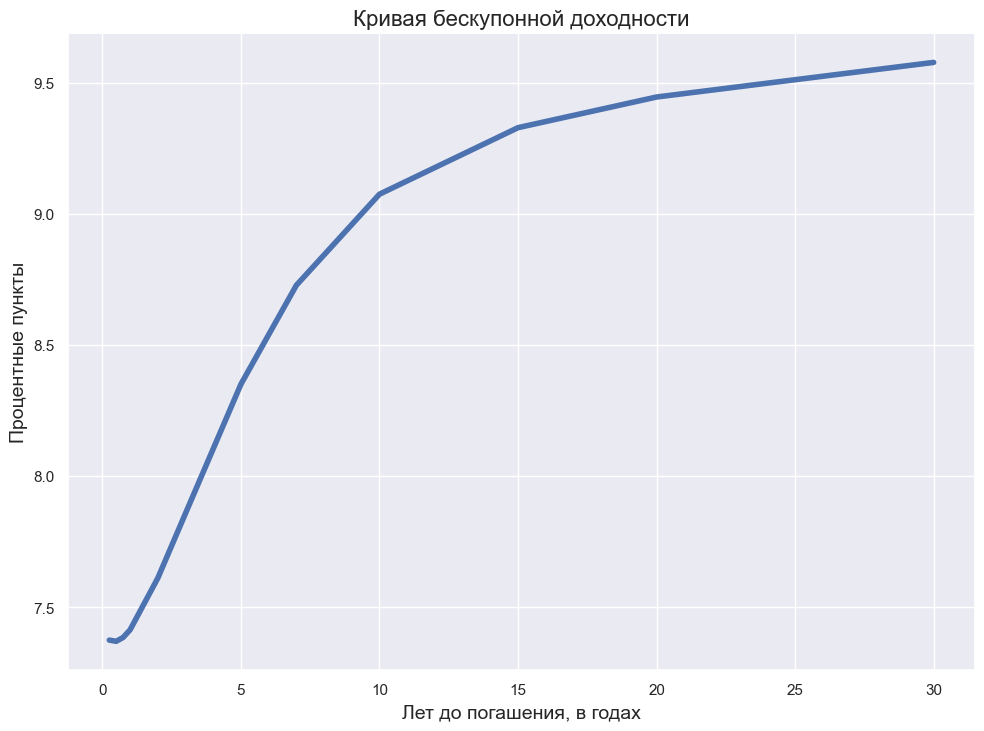

In [225]:
### Добавляем КБД
url = ('http://iss.moex.com/iss/engines/stock/zcyc.csv?iss.only=yearyields')

zcyc_data = requests.get(url).content
zcyc_data = pd.read_csv(io.StringIO(zcyc_data.decode('UTF-8')), sep = ';', header= 1)
zcyc_data.columns = ['Дата записи','Контрольное время', 'Срочность', 'Значение КБД']
print(zcyc_data)

plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], linewidth = 4)
plt.title('Кривая бескупонной доходности', size = 16)
plt.ylabel('Процентные пункты', size = 14)
plt.xlabel('Лет до погашения, в годах', size = 14)

In [226]:
def zcyc_match(df,zcyc_df, mat_column):
    for i in df.index:
        for j in range(len(zcyc_df)-1):
            if df.loc[i,mat_column] == zcyc_df.loc[j,'Срочность']:
                df.loc[i,'КБД'] = zcyc_df.loc[j,'Значение КБД']
            elif (df.loc[i,mat_column] > zcyc_df.loc[j,'Срочность']) & (df.loc[i,mat_column] <= zcyc_df.loc[j+1,'Срочность']):
                df.loc[i,'КБД'] = zcyc_df.loc[j,'Значение КБД']+(df.loc[i,mat_column]/zcyc_df.loc[j+1,'Срочность'])*(zcyc_df.loc[j+1,'Значение КБД']-zcyc_df.loc[j,'Значение КБД'])
            elif df.loc[i, mat_column] > max(zcyc_df['Срочность']):
                df.loc[i,'КБД'] = zcyc_df['Значение КБД'].iloc[-1]
            elif df.loc[i, mat_column] < min(zcyc_df['Срочность']):
                df.loc[i,'КБД'] = zcyc_df['Значение КБД'].iloc[0]

In [227]:
zcyc_match(new_data,zcyc_data,'Лет до погашения')
new_data['Риск-премия'] = new_data['REALBONDYIELD'] - new_data['КБД']
new_data = new_data[new_data['Лет до погашения'] > 0] 

count    2205.000000
mean        6.454800
std         5.558821
min         0.416667
25%         3.000000
50%         4.916667
75%         6.916667
max        91.083333
Name: Срочность инструмента, dtype: float64


Text(0, 0.5, 'N выпусков')

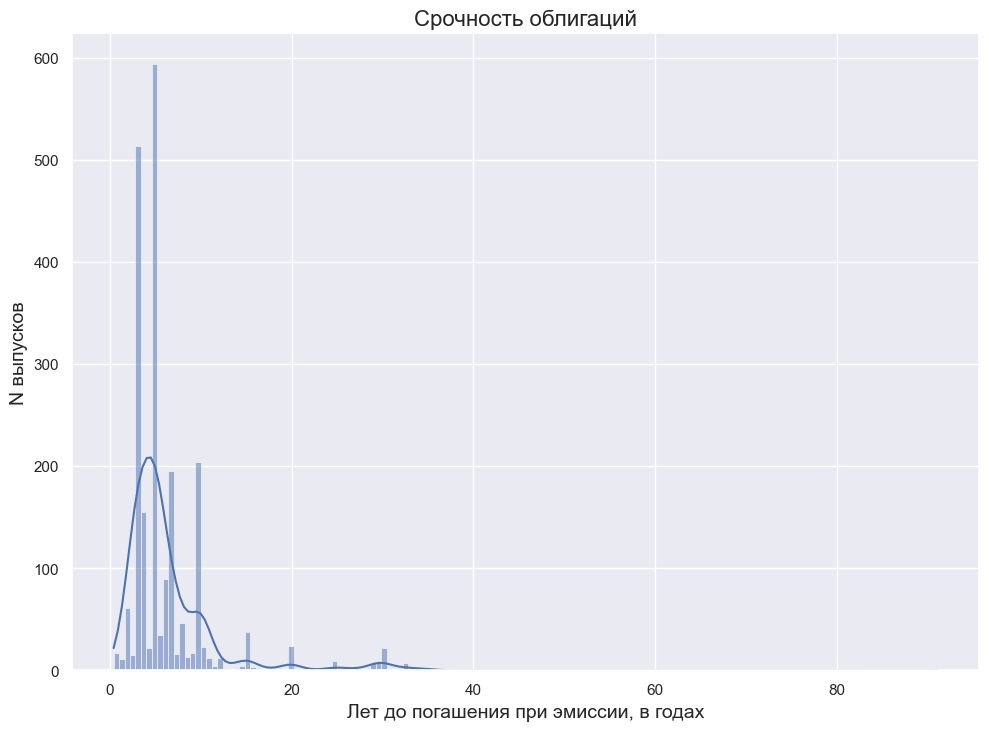

In [228]:
# На какой срок выпускали бумаги?
print(new_data['Срочность инструмента'].describe())
fig = sns.histplot(new_data, x = 'Срочность инструмента', kde = True)
plt.title('Срочность облигаций', size = 16)
plt.xlabel('Лет до погашения при эмиссии, в годах', size = 14)
plt.ylabel('N выпусков', size = 14)


count    2205.000000
mean        3.287339
std         4.598663
min         0.083333
25%         1.083333
50%         2.250000
75%         3.583333
max        88.250000
Name: Лет до погашения, dtype: float64


Text(0, 0.5, 'N выпусков')

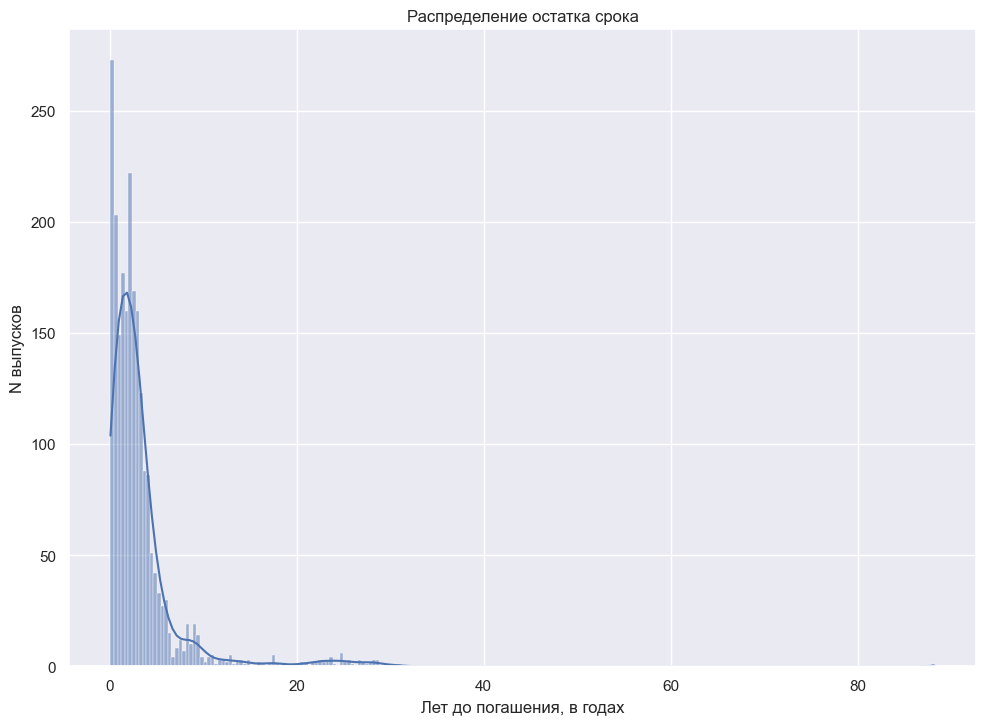

In [229]:
# Сколько осталось до погашения?
print(new_data['Лет до погашения'].describe())
fig = sns.histplot(new_data, x = 'Лет до погашения', kde = True)
plt.title('Распределение остатка срока')
plt.xlabel('Лет до погашения, в годах')
plt.ylabel('N выпусков')


count    2130.000000
mean       31.360563
std       105.523979
min         0.000000
25%         0.000000
50%         0.000000
75%        19.750000
max      1836.000000
Name: NUMTRADES, dtype: float64


Text(0, 0.5, 'N выпусков')

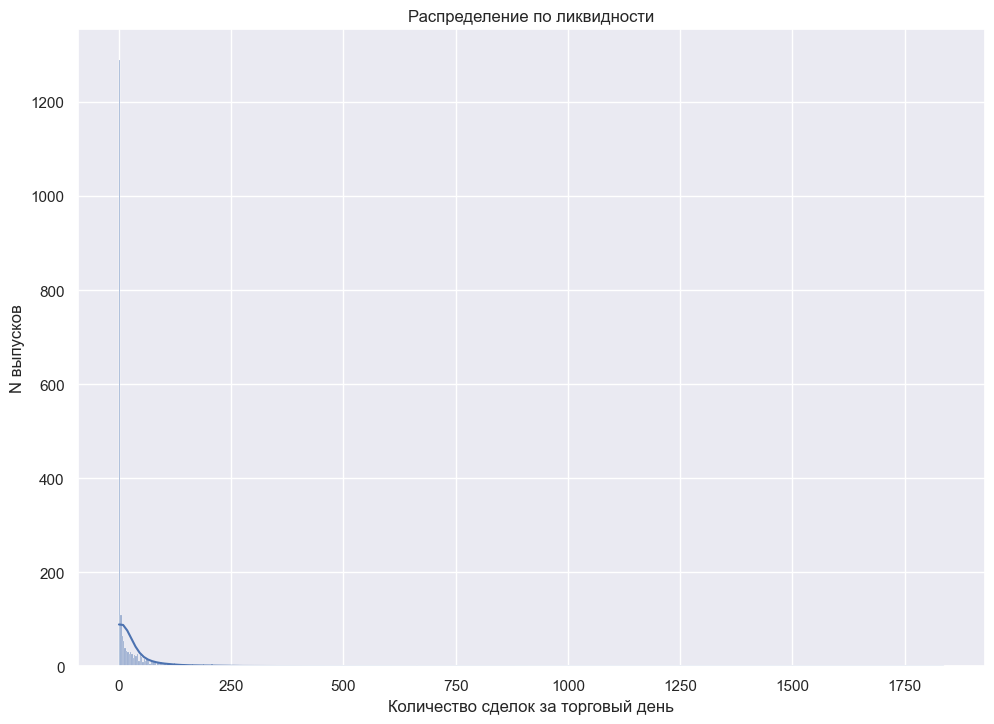

In [230]:
# ликвидность?
print(new_data['NUMTRADES'].describe())
fig = sns.histplot(new_data, x = 'NUMTRADES', kde = True)
plt.title('Распределение по ликвидности')
plt.xlabel('Количество сделок за торговый день')
plt.ylabel('N выпусков')


count    2205.000000
mean        6.632796
std         5.123778
min         0.000100
25%         1.186687
50%         7.180000
75%         9.474000
max        45.014000
Name: Годовой купон в %, dtype: float64


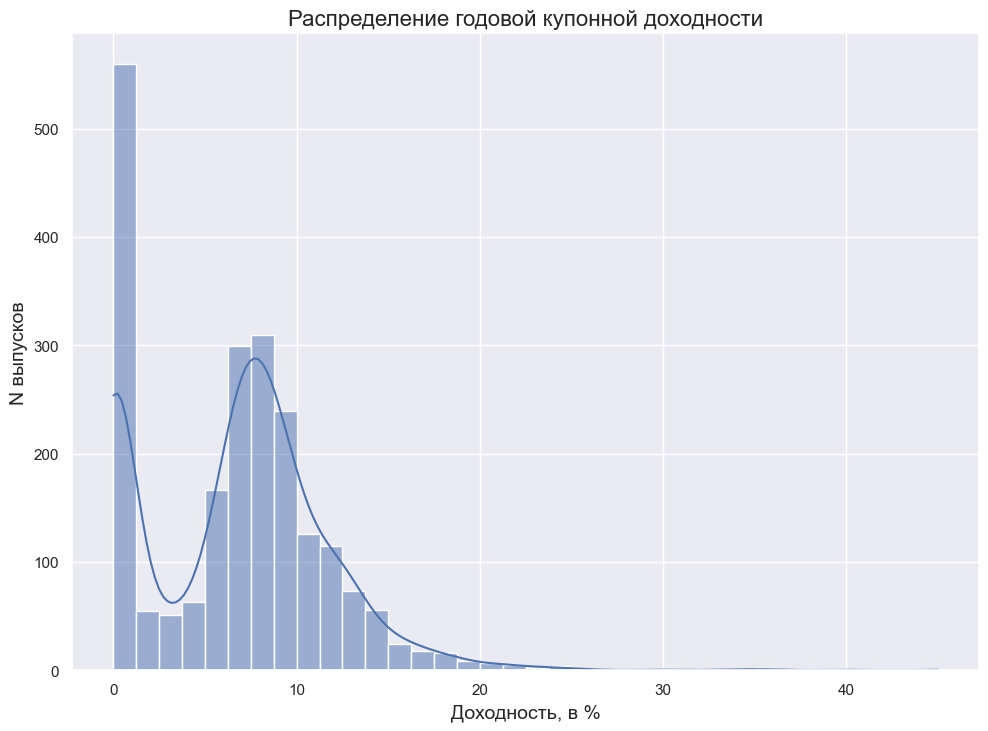

In [231]:
# Как распределена Годовой купон в %?
fig = sns.histplot(new_data, x = 'Годовой купон в %', kde = True)
plt.title('Распределение годовой купонной доходности', size = 16)
plt.xlabel('Доходность, в %', size = 14)
plt.ylabel('N выпусков', size = 14)
print(new_data['Годовой купон в %'].describe())

<AxesSubplot:xlabel='Лет до погашения', ylabel='Годовой купон в %'>

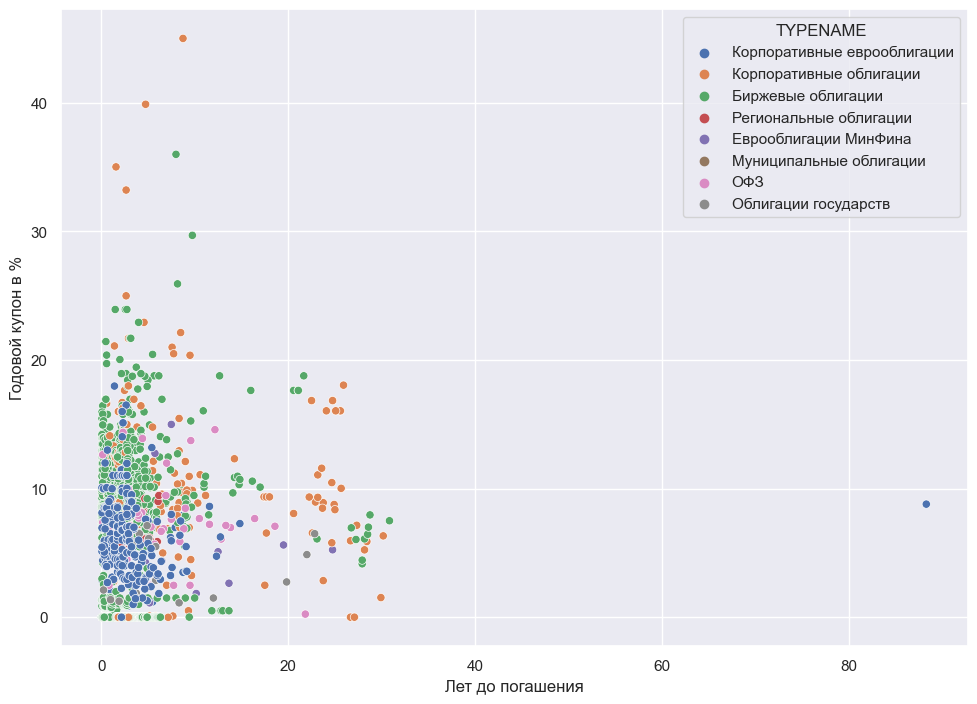

In [232]:
# Распределение облигаций по доходности и сроку погашения

sns.scatterplot(data = new_data, 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME')

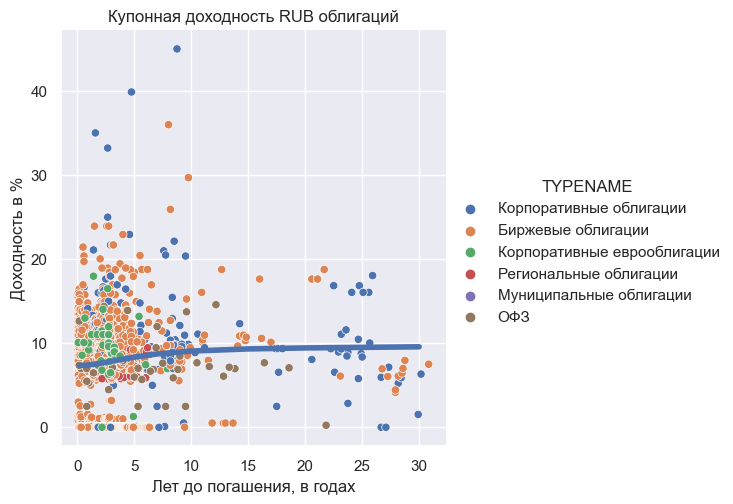

       Годовой купон в %  Лет до погашения
count        1946.000000       1946.000000
mean            6.852550          3.191975
std             5.330317          4.277736
min             0.000100          0.083333
25%             0.100000          1.000000
50%             7.530714          2.166667
75%             9.776534          3.500000
max            45.014000         30.833333


In [233]:
# RUB облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'RUB'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.ylabel('Доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Купонная доходность RUB облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД', linewidth = 4)
plt.show()
print(new_data[new_data['FACEUNIT'] == 'RUB'][['Годовой купон в %','Лет до погашения']].describe())

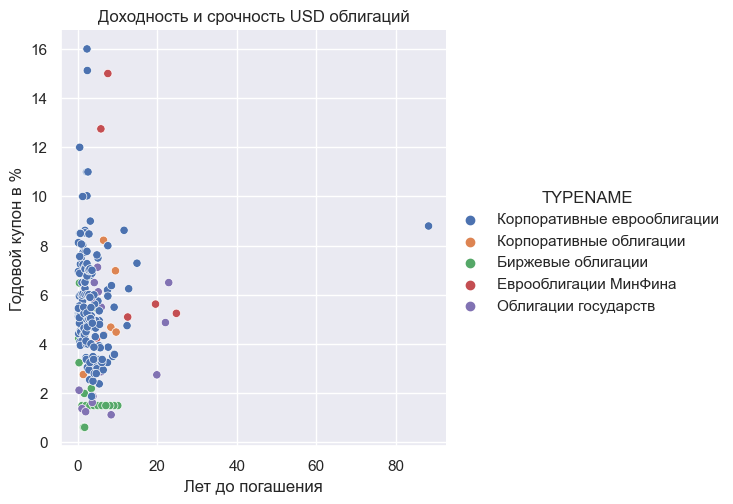

       Годовой купон в %  Лет до погашения
count         214.000000        214.000000
mean            5.309227          4.144081
std             2.629347          6.991547
min             0.614946          0.083333
25%             3.490103          1.333333
50%             5.058300          2.750000
75%             6.678600          4.750000
max            16.000000         88.250000


In [234]:
# Долларовые облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'USD'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность USD облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'USD'][['Годовой купон в %','Лет до погашения']].describe())

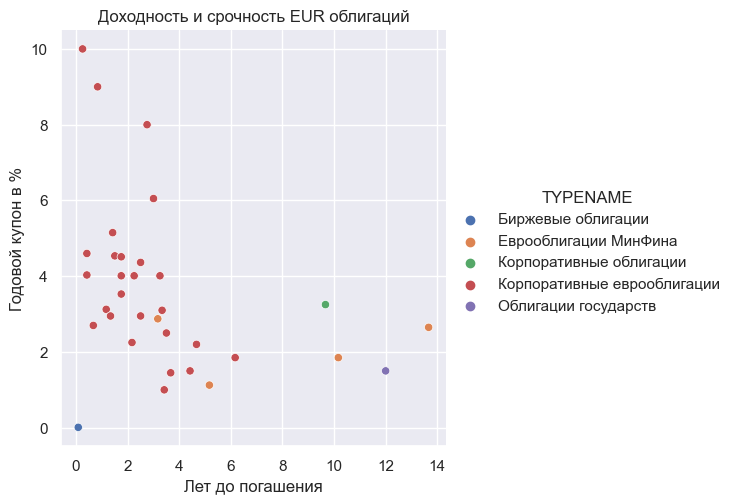

       Годовой купон в %  Лет до погашения
count          33.000000         33.000000
mean            3.534574          3.477273
std             2.206187          3.356901
min             0.010000          0.083333
25%             2.200000          1.416667
50%             3.100000          2.500000
75%             4.364000          3.666667
max            10.000000         13.666667


In [235]:
# Евро облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'EUR'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность EUR облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'EUR'][['Годовой купон в %','Лет до погашения']].describe())

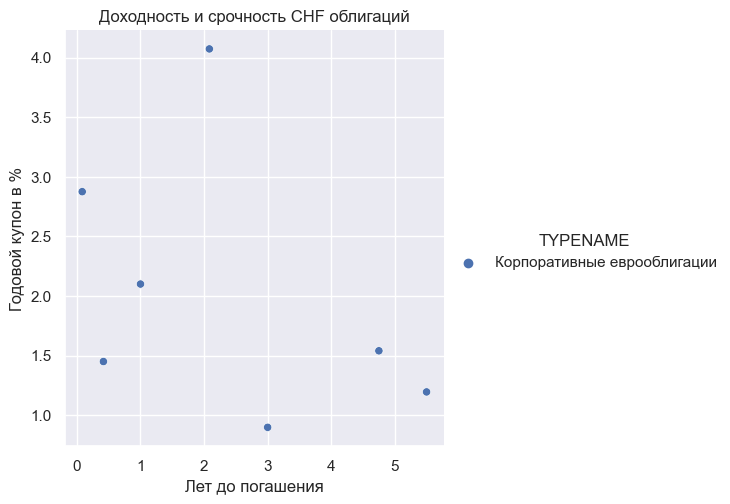

       Годовой купон в %  Лет до погашения
count           7.000000          7.000000
mean            2.018657          2.404762
std             1.113956          2.115545
min             0.898000          0.083333
25%             1.322500          0.708333
50%             1.540000          2.083333
75%             2.487500          3.875000
max             4.072600          5.500000


In [236]:
# CHF облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CHF'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CHF облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CHF'][['Годовой купон в %','Лет до погашения']].describe())

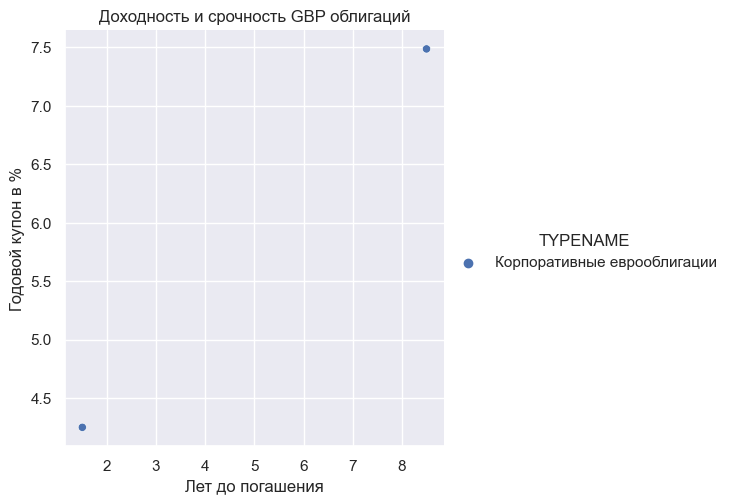

       Годовой купон в %  Лет до погашения
count           2.000000          2.000000
mean            5.868500          5.000000
std             2.288905          4.949747
min             4.250000          1.500000
25%             5.059250          3.250000
50%             5.868500          5.000000
75%             6.677750          6.750000
max             7.487000          8.500000


In [237]:
# GBP облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'GBP'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность GBP облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'GBP'][['Годовой купон в %','Лет до погашения']].describe())

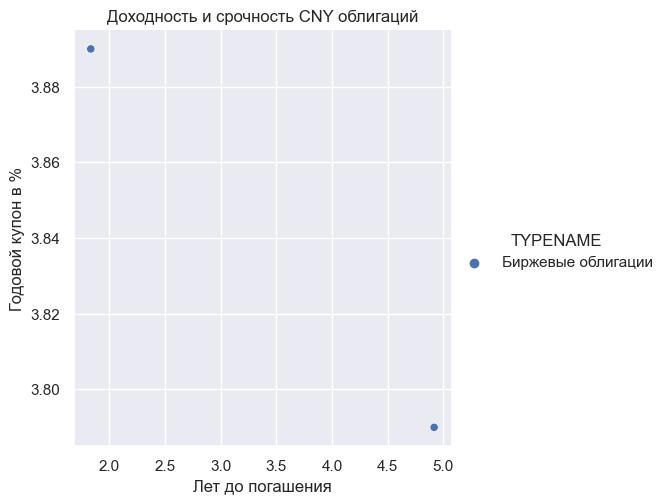

       Годовой купон в %  Лет до погашения
count           3.000000          3.000000
mean            3.856667          2.861111
std             0.057735          1.780163
min             3.790000          1.833333
25%             3.840000          1.833333
50%             3.890000          1.833333
75%             3.890000          3.375000
max             3.890000          4.916667


In [238]:
# CNY облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CNY'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CNY облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CNY'][['Годовой купон в %','Лет до погашения']].describe())

In [239]:
### Ищем кластеры - по валютам!
clusters_data = new_data[['SECID','LISTLEVEL','HIGH_RISK','IS_RII','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия','NUMTRADES']][new_data['FACEUNIT'] == 'RUB']
clusters_data = clusters_data.set_index('SECID')
clusters_data.dropna(inplace= True)

Для числа кластеров = 2 Среднее значение силуэта : 0.9681278979439539
Для числа кластеров = 3 Среднее значение силуэта : 0.8939850450735418
Для числа кластеров = 4 Среднее значение силуэта : 0.9016867265435135
Для числа кластеров = 5 Среднее значение силуэта : 0.8651503342723379
Для числа кластеров = 6 Среднее значение силуэта : 0.7022937602620465
Для числа кластеров = 7 Среднее значение силуэта : 0.6970763503332748
Для числа кластеров = 8 Среднее значение силуэта : 0.5463744078314514
Для числа кластеров = 9 Среднее значение силуэта : 0.5463423244267926
Для числа кластеров = 10 Среднее значение силуэта : 0.5428596288011701
Для числа кластеров = 20 Среднее значение силуэта : 0.3734851783125019
Для числа кластеров = 30 Среднее значение силуэта : 0.339662504489973
Для числа кластеров = 40 Среднее значение силуэта : 0.2974221647024123
Для числа кластеров = 50 Среднее значение силуэта : 0.27988838644459735
Для числа кластеров = 60 Среднее значение силуэта : 0.26937620118486566
Для числа кла

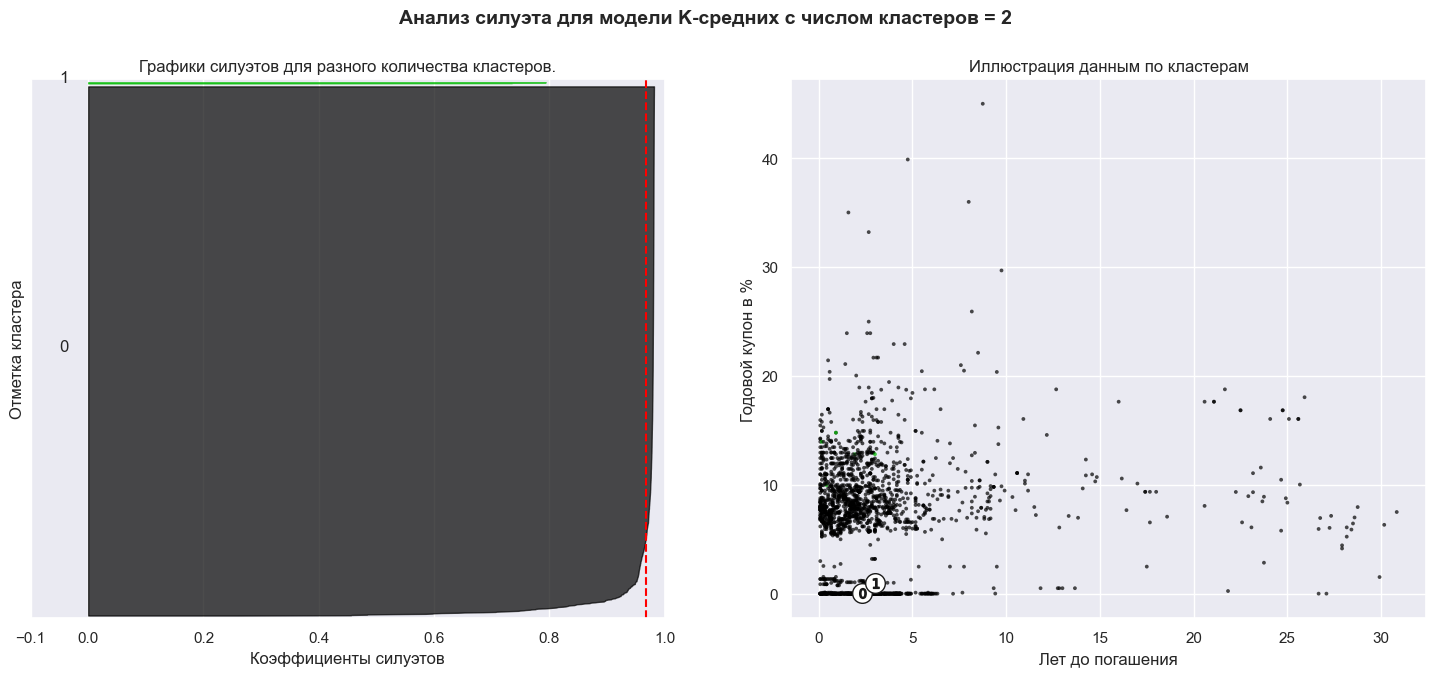

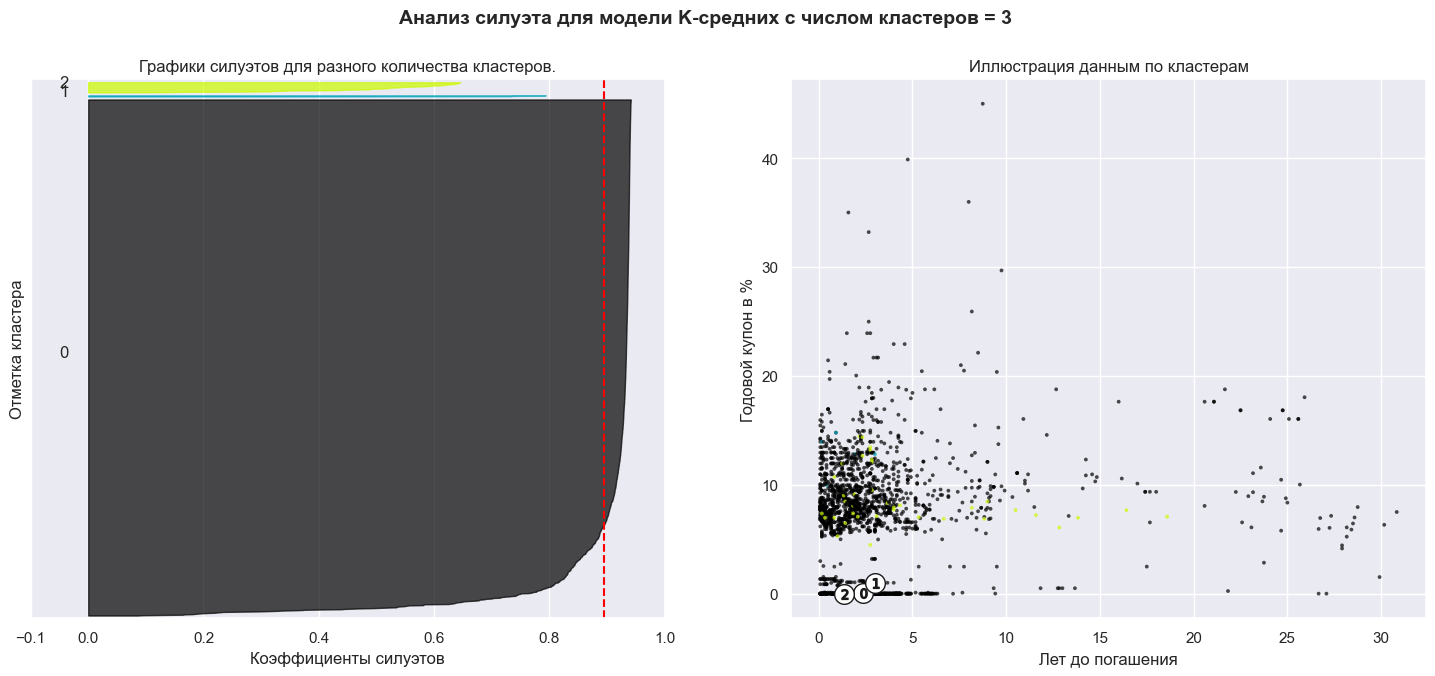

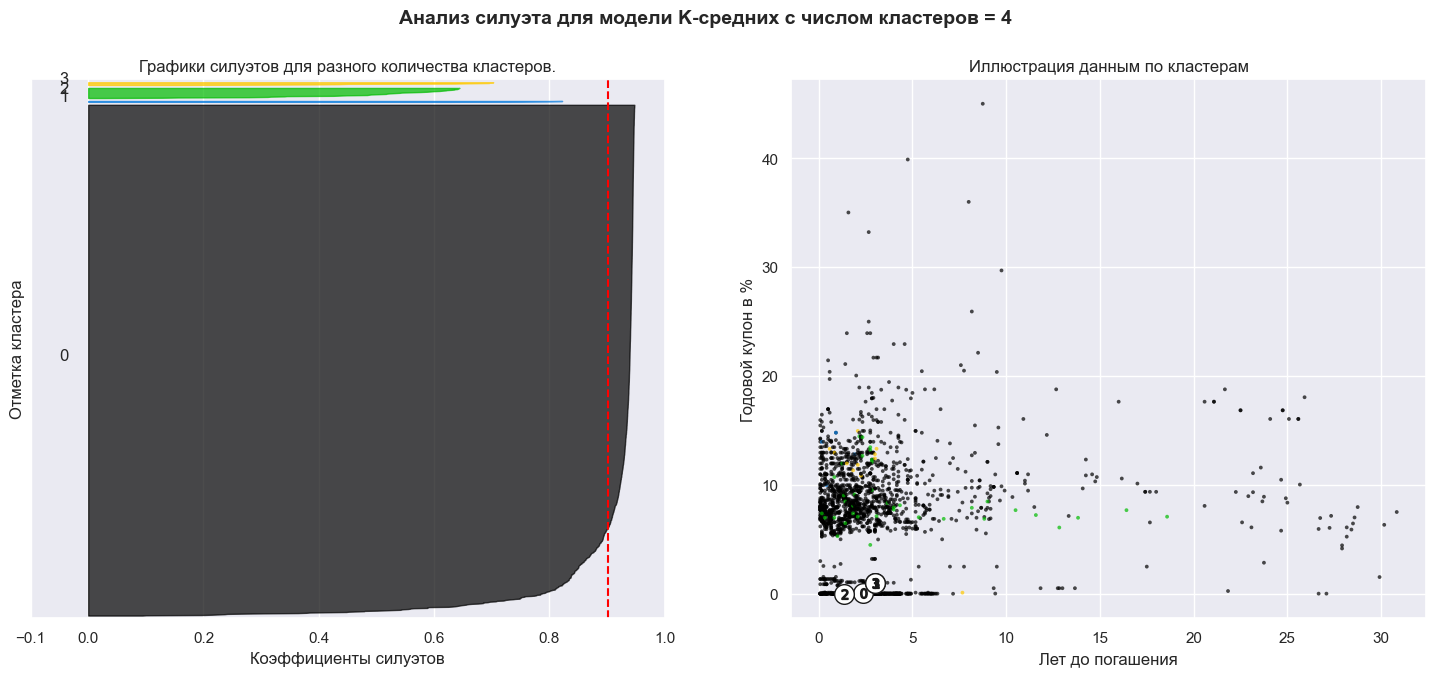

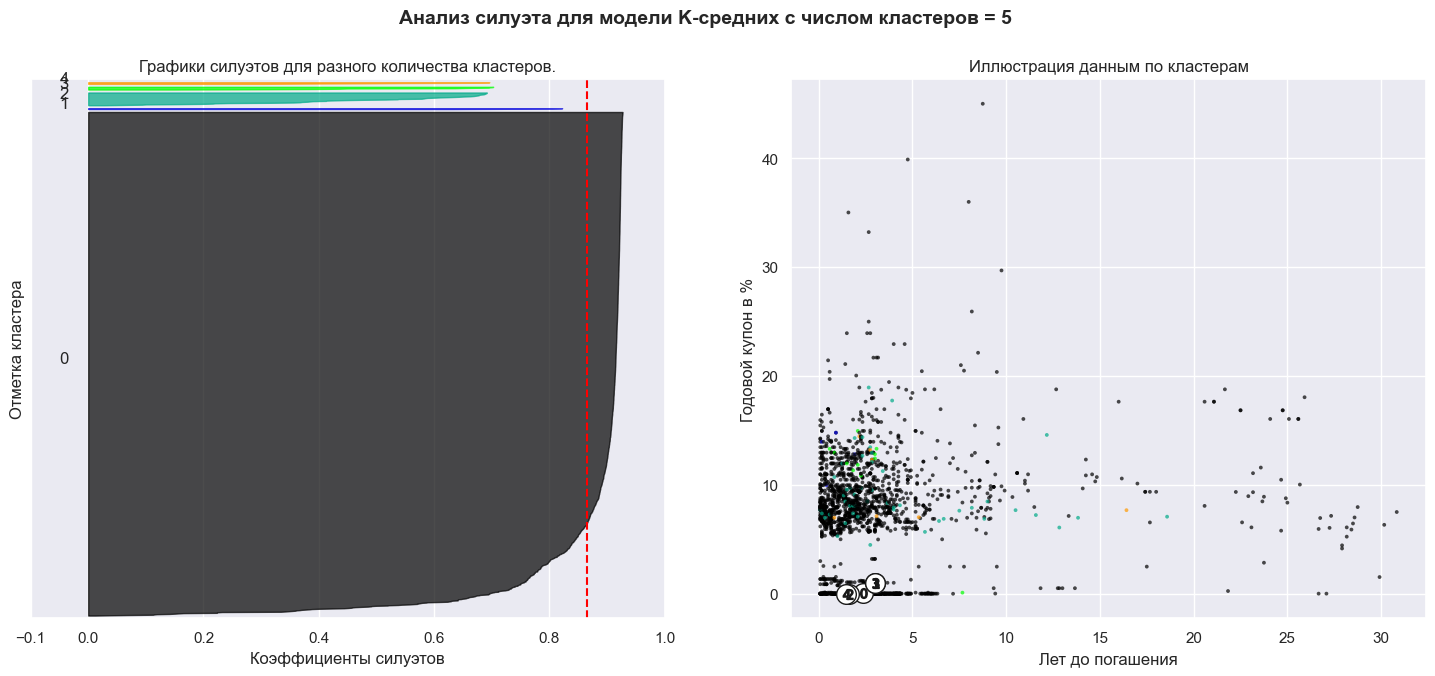

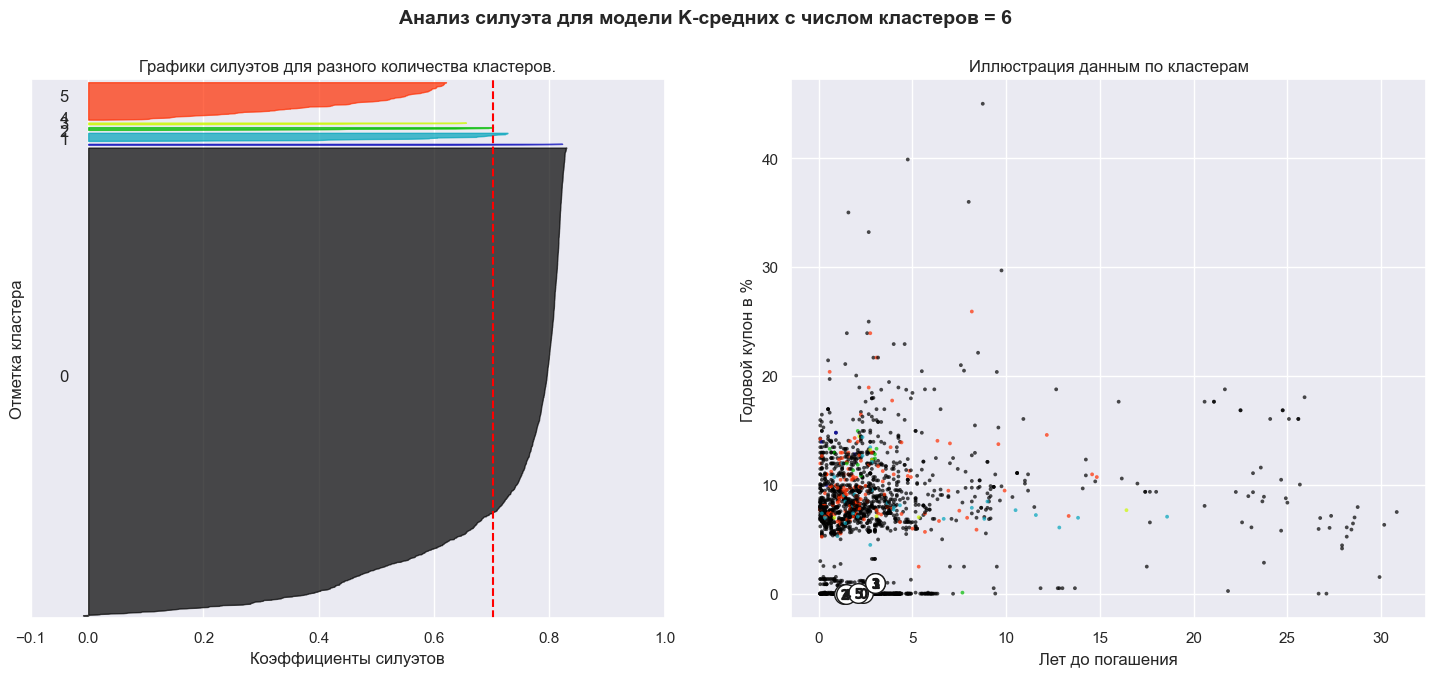

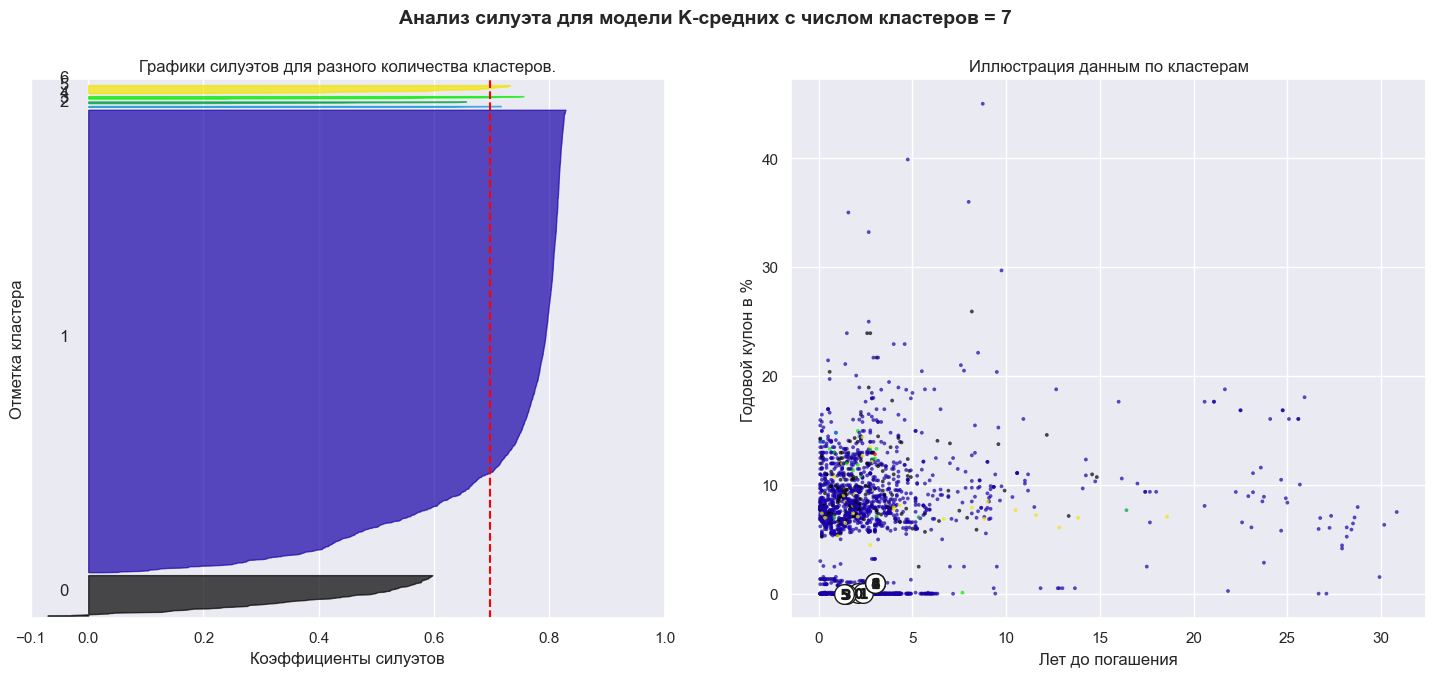

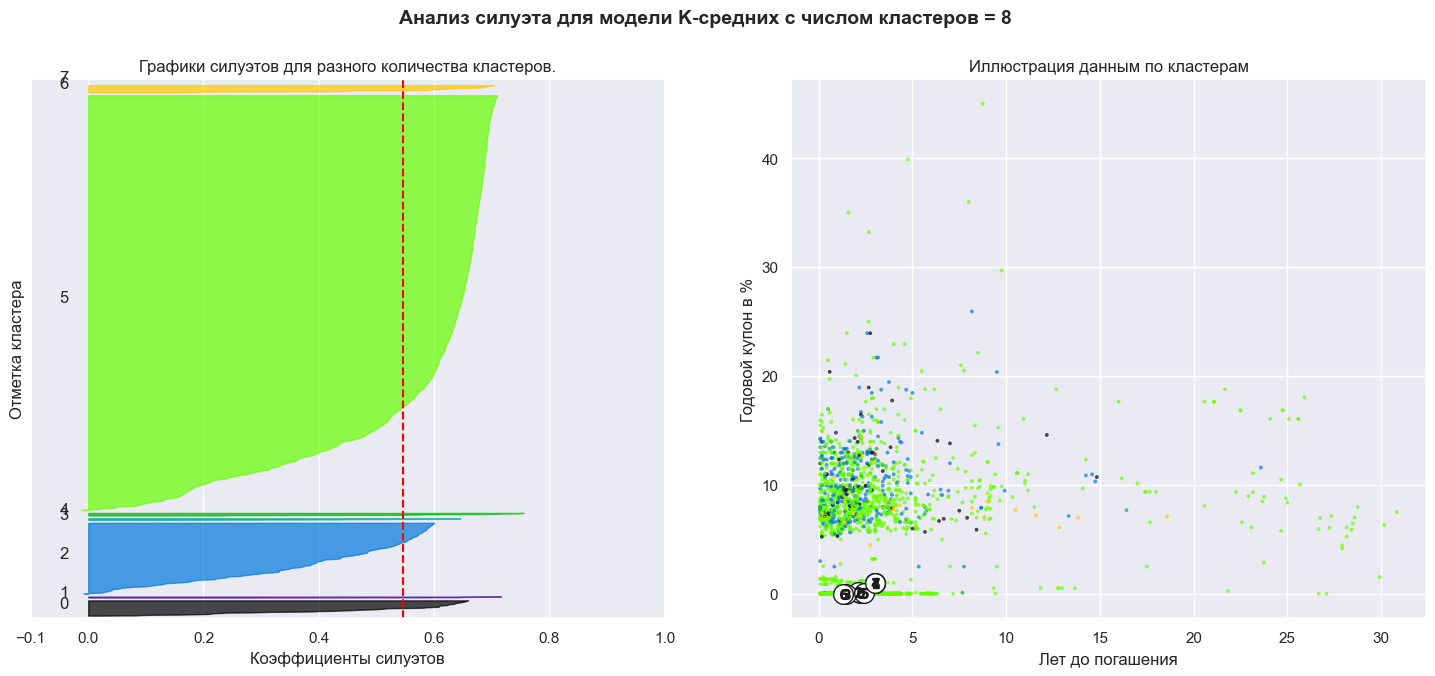

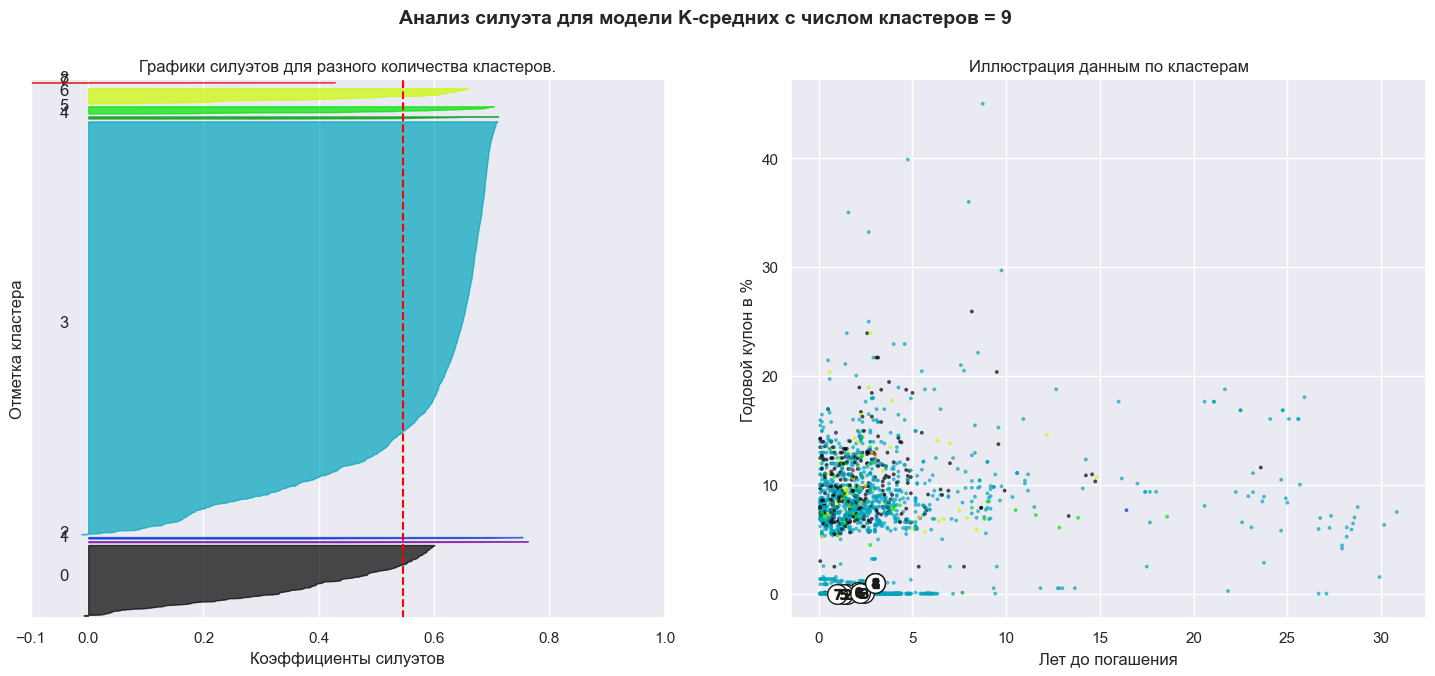

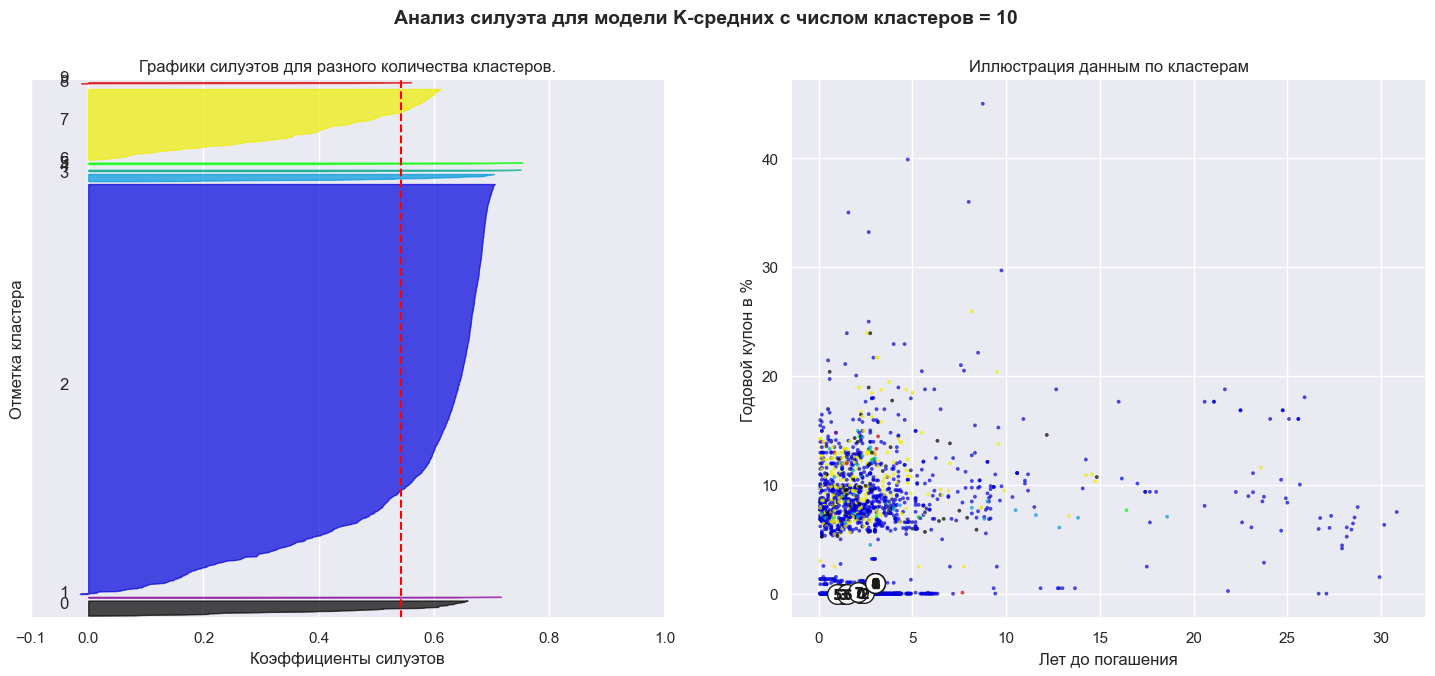

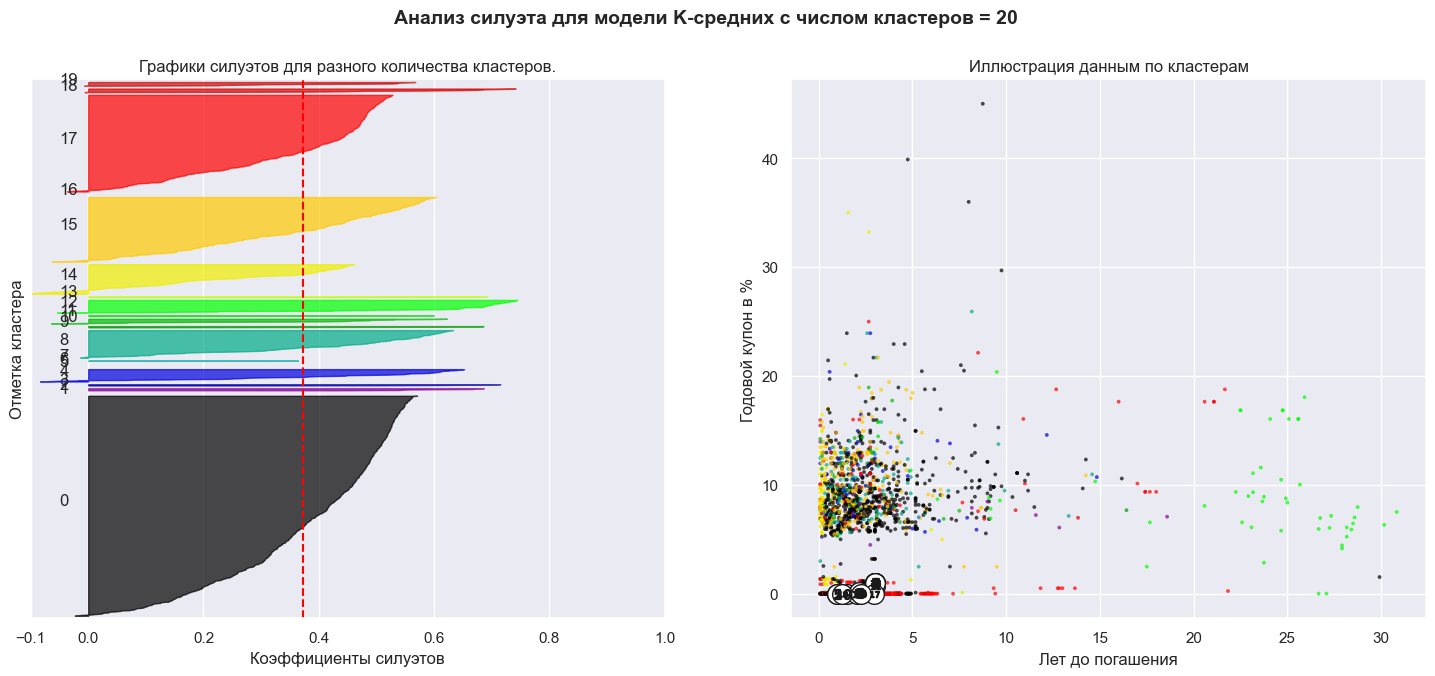

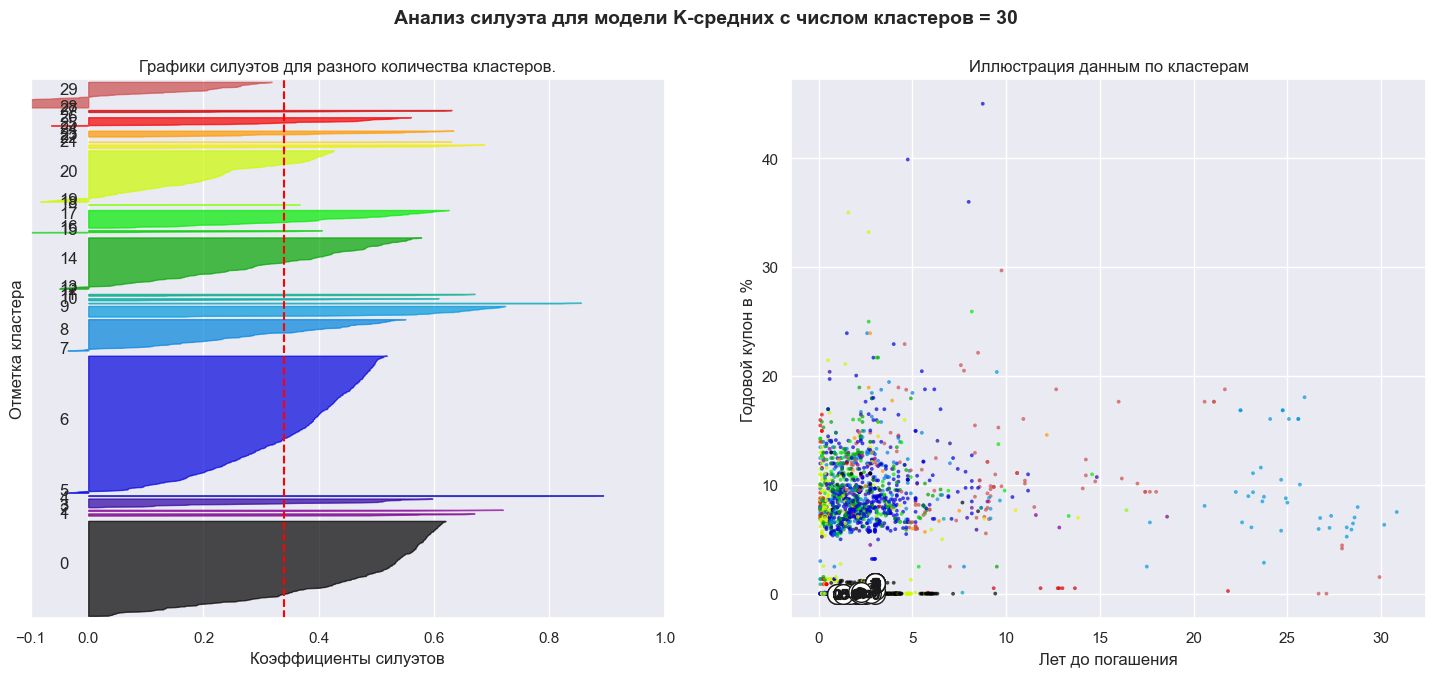

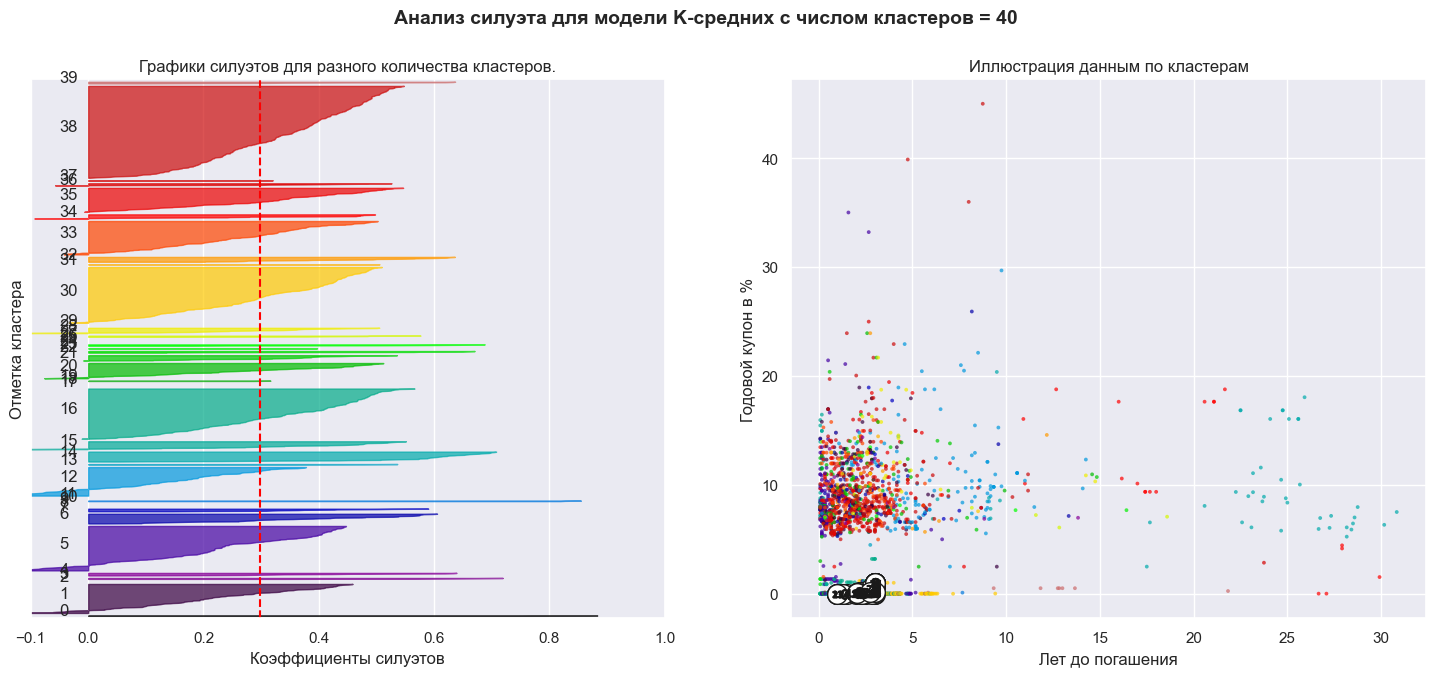

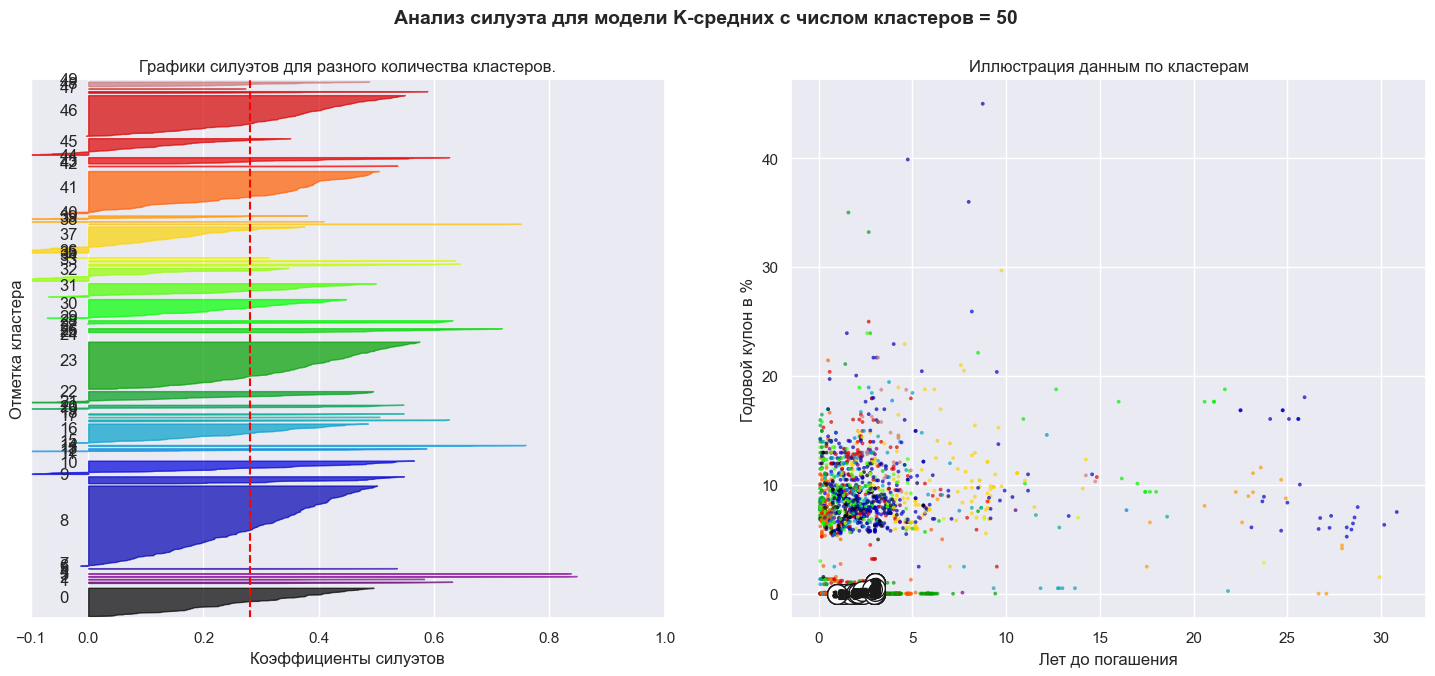

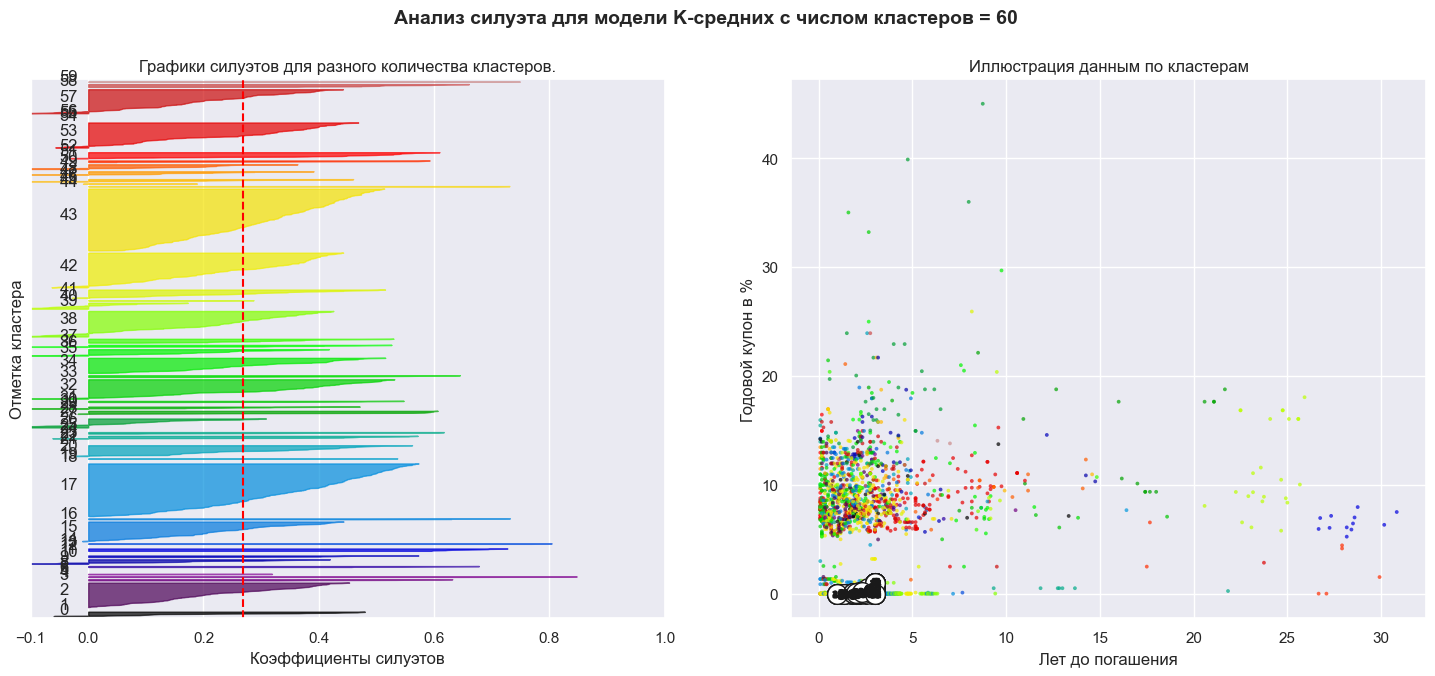

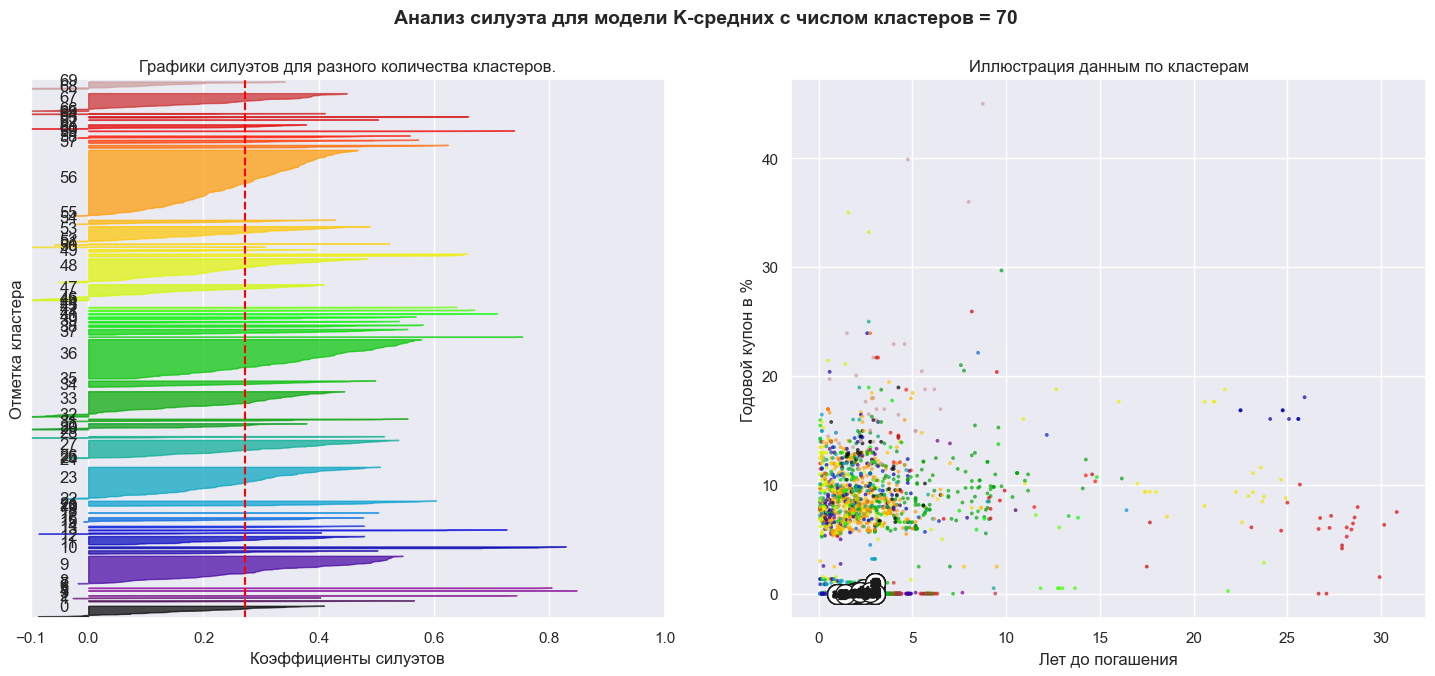

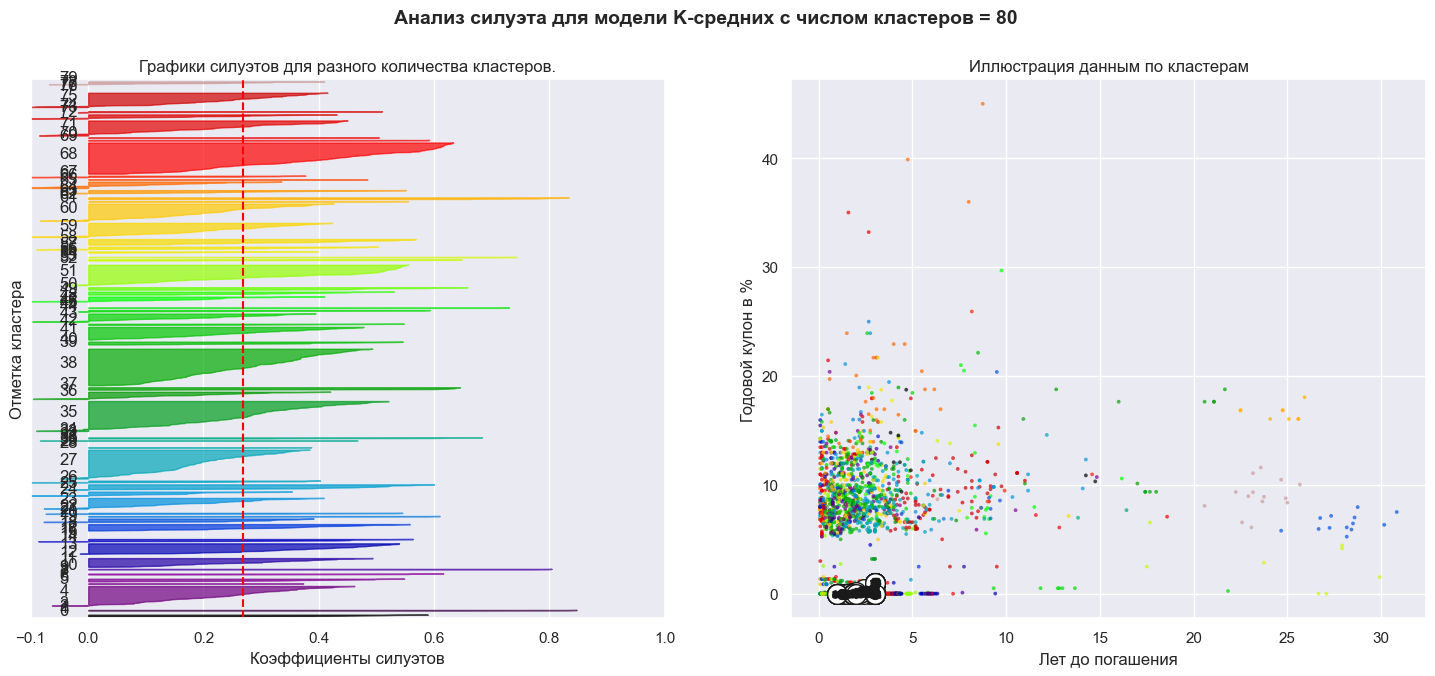

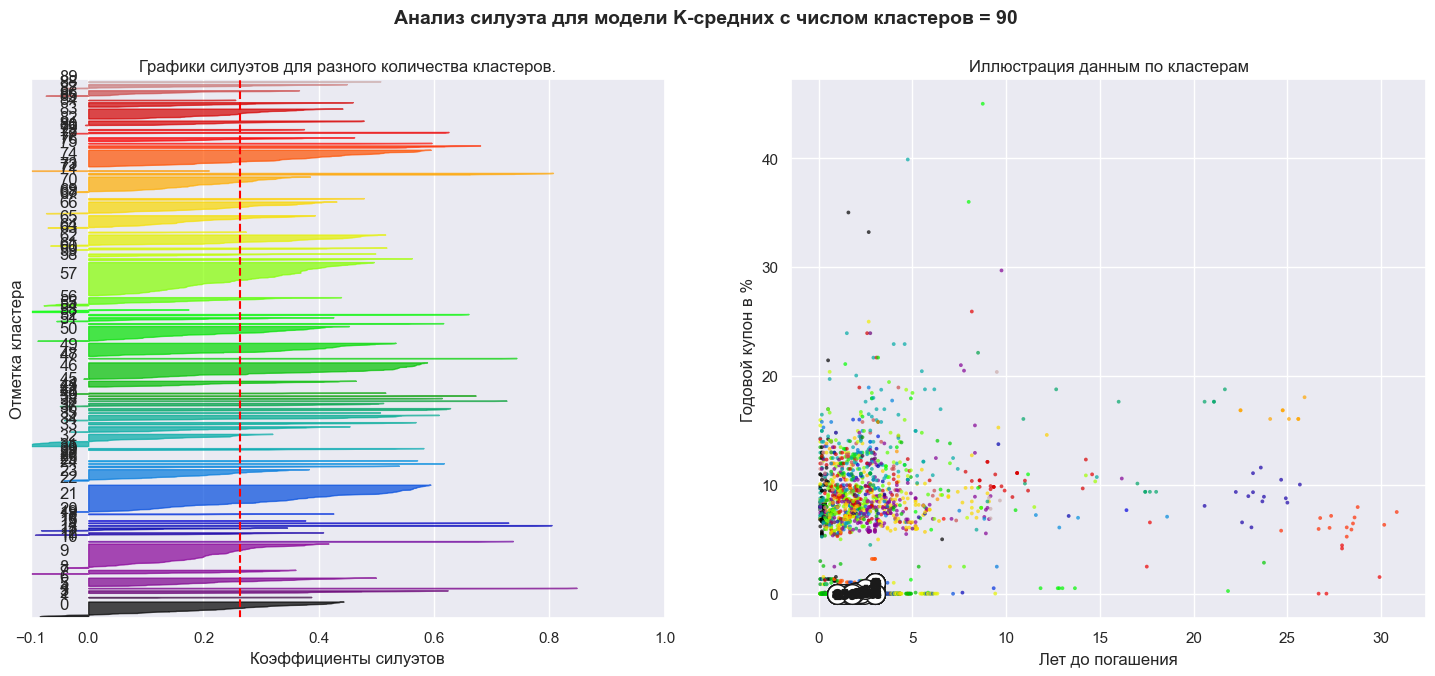

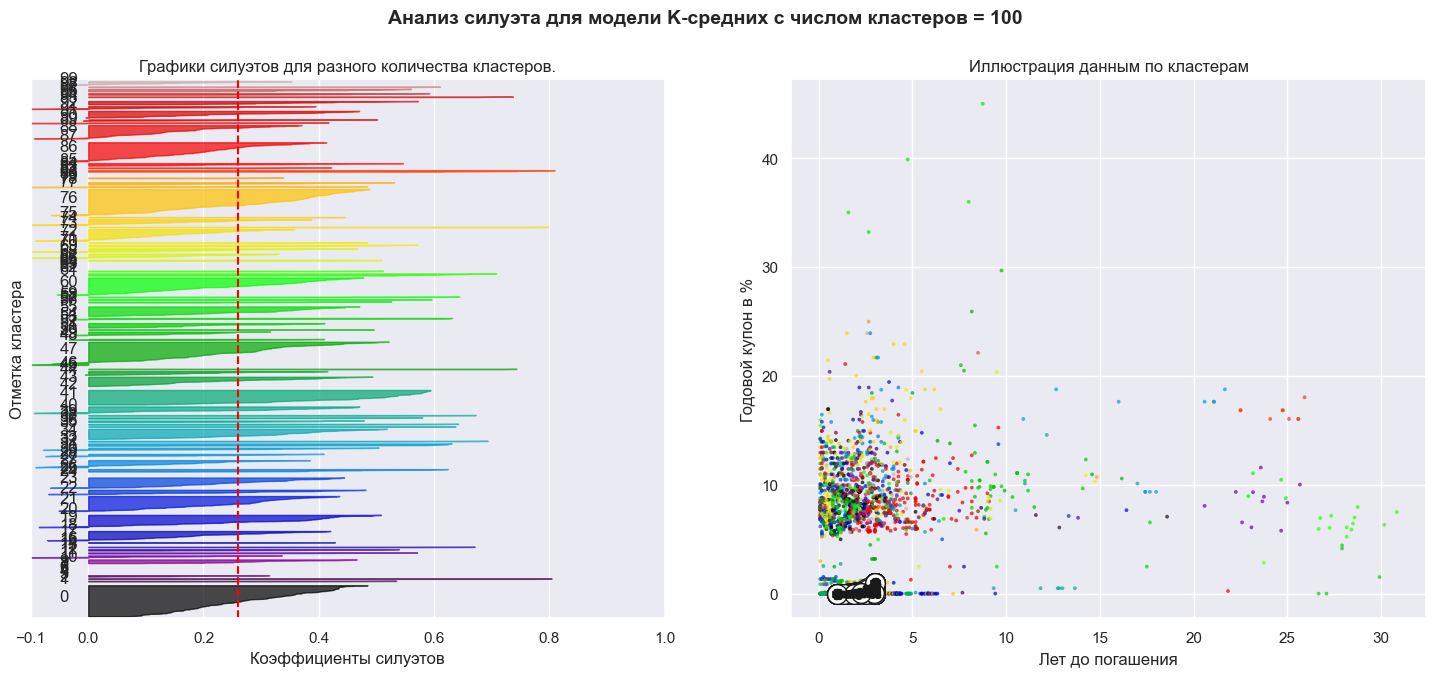

In [240]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusters_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1481)
    cluster_labels = clusterer.fit_predict(clusters_data)

    # The silhouette_score gives the average value for all the samples
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clusters_data, cluster_labels)
    print(
        "Для числа кластеров =",
        n_clusters,
        "Среднее значение силуэта :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clusters_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Графики силуэтов для разного количества кластеров.")
    ax1.set_xlabel("Коэффициенты силуэтов")
    ax1.set_ylabel("Отметка кластера")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        clusters_data.loc[:, 'Лет до погашения'], clusters_data.loc[:, 'Годовой купон в %'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Иллюстрация данным по кластерам")
    ax2.set_xlabel("Лет до погашения")
    ax2.set_ylabel("Годовой купон в %")

    plt.suptitle(
        "Анализ силуэта для модели K-средних с числом кластеров = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

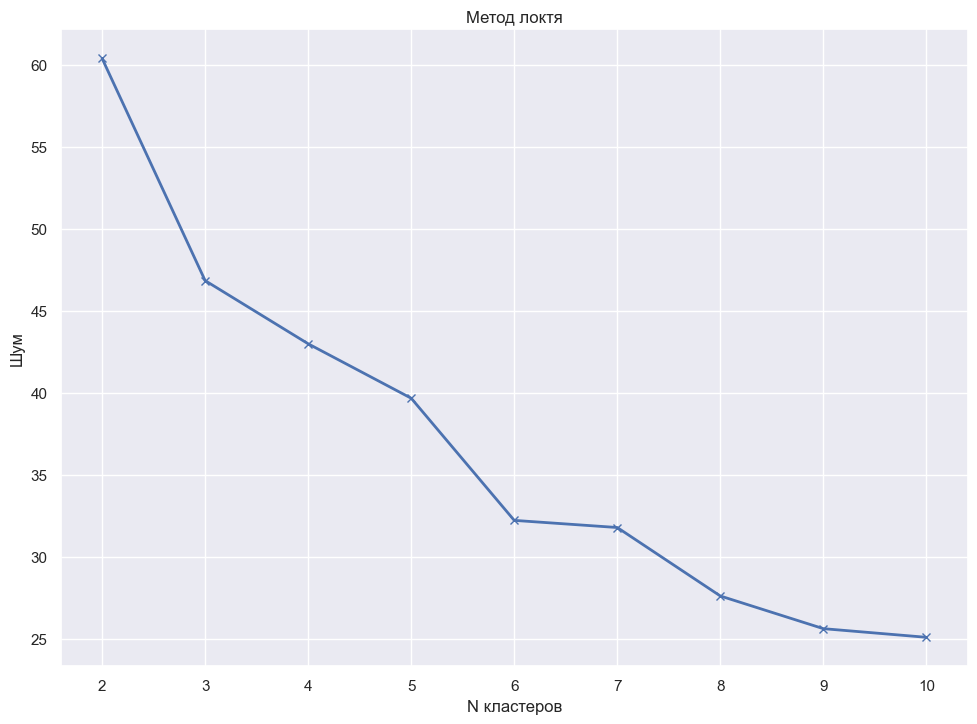

In [241]:
# https://medium.com/@masarudheena/4-best-ways-to-find-optimal-number-of-clusters-for-clustering-with-python-code-706199fa957c
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(clusters_data)
    kmeanModel.fit(clusters_data)
    distortions.append(sum(np.min(cdist(clusters_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clusters_data.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth = 2)
plt.xlabel('N кластеров')
plt.ylabel('Шум')
plt.title('Метод локтя')
plt.show()

Часть вторая: отбор оптимальных облигаций

In [242]:
### Отбираем низкий риск
## Первый котировальный список
## Валюта - строго RUB
## SECSUBTYPE - пропуск, т.к. сложные продукты
## HIGH_RISK == 0
## IS_QUALIFIED_INVESTORS == 0
## Премия от КБД > 0 и < 5 п.п.

final_data = new_data[new_data['Период НКД'] >= 0.2]
sample_data = final_data[(
    (new_data['LISTLEVEL'] == 1)|((new_data['LISTLEVEL'] == 2)))&
    (new_data['FACEUNIT']=='RUB')&
    (new_data['HIGH_RISK']==0)&
    (new_data['SECSUBTYPE'].isna())&
    (new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    (new_data['REALBONDYIELD']>0)&
    (abs(new_data['Переоценка в %'])<=10)&
    (new_data['Риск-премия']>0)&
    (new_data['Риск-премия']<0.5*new_data['КБД'])&
    (new_data['NUMTRADES']>0)]
sample_data = sample_data[['SECID','TYPENAME','Лет до погашения','REALBONDYIELD','Финальная дата','FACEVALUE','Рыночная цена','Переоценка в %','COUPONVALUE','Годовой купон в %','НКД','КБД','Риск-премия']]
sample_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)

C:\Users\mikha\AppData\Local\Temp\ipykernel_14000\2832667875.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_data = final_data[(


,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,КБД,Риск-премия
481,RU000A0ZYJH7,Биржевые облигации,5.166667,10.825467,2027-11-24,1000.00,1012.50000,1.25,74.79,14.958000,43.969945,8.628662,2.196805
1358,RU000A102952,Биржевые облигации,1.083333,10.405695,2023-10-20,1000.00,947.20000,-5.28,22.44,8.976000,14.549011,7.521162,2.884532
1183,RU000A101UW4,Корпоративные облигации,4.250000,10.184144,2027-01-08,767.65,833.36084,8.56,31.56,16.444994,24.013043,8.276585,1.907559
1842,RU000A103JR3,Биржевые облигации,1.833333,10.138640,2024-08-12,1000.00,959.00000,-4.10,26.43,10.572000,9.294066,7.595075,2.543565
2298,SU29010RMFS4,ОФЗ,12.166667,10.038687,2034-12-06,1000.00,1097.70000,9.77,72.95,14.590000,34.470879,9.280117,0.758571
183,RU000A0JVHH1,Биржевые облигации,2.666667,9.779178,2025-06-04,1000.00,902.20000,-9.78,42.38,8.476000,23.285714,7.830878,1.948300
1281,RU000A1022G1,Биржевые облигации,1.916667,9.721451,2024-08-23,1000.00,965.10000,-3.49,26.05,10.420000,6.011538,7.603288,2.118164
1893,RU000A103QH9,Биржевые облигации,3.916667,9.636549,2026-09-15,1000.00,920.40000,-7.96,22.69,9.076000,21.692637,8.243778,1.392771
2205,RU000A104YT6,Биржевые облигации,2.750000,9.385597,2025-07-11,1000.00,1017.70000,1.77,33.03,13.212000,22.866923,7.837733,1.547863
2212,RU000A104ZK2,Биржевые облигации,2.833333,9.378546,2025-07-22,1000.00,1003.90000,0.39,30.79,12.316000,17.594286,7.844589,1.533957


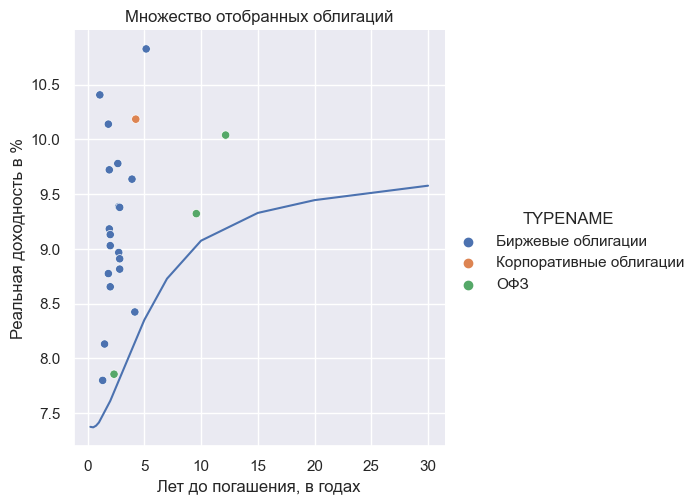

       REALBONDYIELD  Лет до погашения
count      23.000000         23.000000
mean        9.238492          3.289855
std         0.792305          2.623571
min         7.799033          1.083333
25%         8.794623          1.916667
50%         9.182046          2.666667
75%         9.750315          3.375000
max        10.825467         12.166667


In [243]:
sns.relplot(data = sample_data, 
x = 'Лет до погашения', 
y = 'REALBONDYIELD',
hue = 'TYPENAME',
legend = 'full'
)
plt.ylabel('Реальная доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Множество отобранных облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(sample_data[['REALBONDYIELD','Лет до погашения']].describe())

In [244]:
top_bonds = sample_data.sort_values(by = 'Риск-премия',ascending=False).head(30)
top_bonds

,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,КБД,Риск-премия
1358,RU000A102952,Биржевые облигации,1.083333,10.405695,2023-10-20,1000.00,947.20000,-5.28,22.44,8.976000,14.549011,7.521162,2.884532
1842,RU000A103JR3,Биржевые облигации,1.833333,10.138640,2024-08-12,1000.00,959.00000,-4.10,26.43,10.572000,9.294066,7.595075,2.543565
481,RU000A0ZYJH7,Биржевые облигации,5.166667,10.825467,2027-11-24,1000.00,1012.50000,1.25,74.79,14.958000,43.969945,8.628662,2.196805
1281,RU000A1022G1,Биржевые облигации,1.916667,9.721451,2024-08-23,1000.00,965.10000,-3.49,26.05,10.420000,6.011538,7.603288,2.118164
183,RU000A0JVHH1,Биржевые облигации,2.666667,9.779178,2025-06-04,1000.00,902.20000,-9.78,42.38,8.476000,23.285714,7.830878,1.948300
1183,RU000A101UW4,Корпоративные облигации,4.250000,10.184144,2027-01-08,767.65,833.36084,8.56,31.56,16.444994,24.013043,8.276585,1.907559
1849,RU000A103L03,Биржевые облигации,1.916667,9.182046,2024-08-21,1000.00,956.70000,-4.33,22.81,9.124000,5.765165,7.603288,1.578759
2205,RU000A104YT6,Биржевые облигации,2.750000,9.385597,2025-07-11,1000.00,1017.70000,1.77,33.03,13.212000,22.866923,7.837733,1.547863
2212,RU000A104ZK2,Биржевые облигации,2.833333,9.378546,2025-07-22,1000.00,1003.90000,0.39,30.79,12.316000,17.594286,7.844589,1.533957
1910,RU000A103RY2,Биржевые облигации,2.000000,9.130312,2024-09-24,1000.00,963.10000,-3.69,24.68,9.872000,21.696703,7.611500,1.518812


In [245]:
with pd.ExcelWriter(directory_path+'\\'+r'Результаты'+'\\Анализ облигаций РМА ' + datetime.datetime.now().strftime('%Y %m %d %H-%M-%S') +  '.xlsx', mode='w') as writer:    
    sample_data.to_excel(writer, sheet_name = 'Выборка', index = False)
    zcyc_data.to_excel(writer, sheet_name = 'КБД', index = False)
    top_bonds.to_excel(writer, sheet_name = 'Оптимальный выбор')

In [246]:
rob_check = new_data[(new_data['Период НКД'] >= 0.2)&(new_data['Лет до погашения'] <2 )]
#rob_check = rob_check[
    #(new_data['LISTLEVEL'] == 1)&
    #(new_data['FACEUNIT']=='RUB')&
    #(new_data['HIGH_RISK']==0)&
    #(new_data['SECSUBTYPE'].isna())&
    #(new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    #(new_data['REALBONDYIELD']>0)&
    #(abs(new_data['Переоценка в %'])<=10)&
    #(new_data['Риск-премия']>0)&
   # (new_data['Риск-премия']<0.5*new_data['КБД'])&
    #(new_data['Лет до погашения']<=2)]
rob_check.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,N оставшихся купонов,Валютный риск,Годовой купон в %,Лет до погашения,Срочность инструмента,Период НКД,Переоценка в %,REALBONDYIELD,КБД,Риск-премия
1050,RU000A101KJ2,Калита1P1,Калита 001Р-01,Биржевые облигации,RU000A101KJ2,4B02-01-00524-R,3.0,1000.0,RUB,300000.0,...,12.0,0,14.7960,0.916667,3.416667,0.966667,-97.30,2500.795068,7.411975,2493.383093
1289,RU000A1023L9,Калита1P2,Калита 001Р-02,Биржевые облигации,RU000A1023L9,4B02-02-00524-R,3.0,1000.0,RUB,300000.0,...,23.0,0,12.8160,1.916667,3.916667,0.600000,-97.64,1829.713585,7.603288,1822.110297
1262,RU000A1021B4,ОРГрупп1Р3,ОР ООО 001P-03,Биржевые облигации,RU000A1021B4,4B02-03-00412-R-001P,3.0,1000.0,RUB,500000.0,...,22.0,0,11.3400,1.833333,3.916667,0.300000,-93.94,840.355495,7.595075,832.760420
1029,RU000A101HQ3,ДДёнерБОП2,Дядя Дёнер ООО БО-П02,Биржевые облигации,RU000A101HQ3,4B02-02-00355-R-001P,3.0,10000.0,RUB,5000.0,...,7.0,0,13.3152,0.583333,3.083333,0.633333,-81.74,671.621754,7.381989,664.239765
2362,XS0842078536,VTB-22,VTB CAPITAL SA 6.95 17/10/22,Корпоративные еврооблигации,XS0842078536,NaN,NaN,1000.0,USD,1500000.0,...,0.0,0,6.9500,0.083333,8.000000,0.830601,-40.28,604.334193,7.374900,596.959293
5,CH0385518086,ALFA-22 CH,Alfa Holding Issuance 09/11/22,Корпоративные еврооблигации,CH0385518086,NaN,NaN,5000.0,CHF,33000.0,...,0.0,0,2.8750,0.083333,4.916667,0.852055,-50.00,528.638127,7.374900,521.263227
1257,RU000A102101,ЭБИС Б1P03,ЭБИС БО-П03,Биржевые облигации,RU000A102101,4B02-03-00360-R-001P,3.0,1000.0,RUB,150000.0,...,3.0,0,12.9640,0.833333,2.916667,0.384615,-81.76,445.709036,7.409550,438.299486
1657,RU000A102ZS9,ЭБИС Б1P04,ЭБИС БО-П04,Биржевые облигации,RU000A102ZS9,4B02-04-00360-R-001P,3.0,1000.0,RUB,400000.0,...,6.0,0,11.9680,1.500000,2.916667,0.725275,-86.89,372.233504,7.562225,364.671279
227,RU000A0JVZB6,ДелоПортс1,ДелоПортс ООО 01,Корпоративные облигации,RU000A0JVZB6,4-01-36485-R,3.0,1000.0,RUB,3000000.0,...,0.0,0,0.0100,0.166667,6.916667,0.653846,-19.52,111.516433,7.374900,104.141533
6,CH0404311711,GAZ-23 CHF,GAZ CAPITAL SA 1.45 6/3/23 CHF,Корпоративные еврооблигации,CH0404311711,NaN,NaN,5000.0,CHF,150000.0,...,0.0,0,1.4500,0.416667,4.916667,0.531507,-32.29,85.098181,7.371150,77.727031


#rob_check = rob_check[
    #(new_data['LISTLEVEL'] == 1)&
    #(new_data['FACEUNIT']=='RUB')&
    #(new_data['HIGH_RISK']==0)&
    #(new_data['SECSUBTYPE'].isna())&
    #(new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    #(new_data['REALBONDYIELD']>0)&
    #(abs(new_data['Переоценка в %'])<=10)&
    #(new_data['Риск-премия']>0)&
   # (new_data['Риск-премия']<0.5*new_data['КБД'])&
    #(new_data['Лет до погашения']<=2)]

In [247]:
### Фильтры
no_listing = final_data[final_data['LISTLEVEL'] != 1]
high_risk = final_data[final_data['HIGH_RISK'] == 1]
non_rub = final_data[final_data['FACEUNIT'] != 'RUB']
complex_prod = final_data[final_data['SECSUBTYPE'].isna() == False]
qual_prod = final_data[final_data['IS_QUALIFIED_INVESTORS'] == 1]
neg_real = final_data[final_data['REALBONDYIELD'] <= 0]
vol_mtm = final_data[final_data['Переоценка в %'] > 10]
neg_prem = final_data[final_data['Риск-премия'] < 0]
high_prem = final_data[final_data['Риск-премия'] >= final_data['КБД']*0.5]

print('Всего облигаций в итоговой выборке:', len(final_data),',', np.round(100*len(final_data)/len(final_data)),'%')
print('Облигаций без первого уровня листинга:', len(no_listing),',', np.round(len(no_listing)/(len(final_data))*100),'%')
print('Облигаций в секторе повышенного риска:', len(high_risk),',', np.round(len(high_risk)/(len(final_data))*100),'%')
print('Облигаций не в рублях:', len(non_rub),',', np.round(len(non_rub)/(len(final_data))*100),'%')
print('Облигации только для квалифицированных инвесторов:',len(complex_prod),',',np.round(len(complex_prod)/(len(final_data))*100),'%')
print('Облигации c отрицательной реальной доходностью:',len(neg_real),',',np.round(len(neg_real)/(len(final_data))*100),'%')
print('Облигации с большой переоценкой:',len(vol_mtm),',',np.round(len(vol_mtm)/(len(final_data))*100),'%')
print('Облигации с отрицательной риск-премией:',len(neg_prem),',',np.round(len(neg_prem)/(len(final_data))*100),'%')
print('Облигации с избыточной риск-премией:',len(high_prem),',',np.round(len(high_prem)/(len(final_data))*100),'%')

Всего облигаций в итоговой выборке: 1807 , 100.0 %
Облигаций без первого уровня листинга: 1384 , 77.0 %
Облигаций в секторе повышенного риска: 94 , 5.0 %
Облигаций не в рублях: 225 , 12.0 %
Облигации только для квалифицированных инвесторов: 76 , 4.0 %
Облигации c отрицательной реальной доходностью: 218 , 12.0 %
Облигации с большой переоценкой: 40 , 2.0 %
Облигации с отрицательной риск-премией: 1280 , 71.0 %
Облигации с избыточной риск-премией: 214 , 12.0 %


In [248]:
final_data = final_data[final_data['Лет до погашения'] <= 2]
no_listing = final_data[final_data['LISTLEVEL'] != 1]
high_risk = final_data[final_data['HIGH_RISK'] == 1]
non_rub = final_data[final_data['FACEUNIT'] != 'RUB']
complex_prod = final_data[final_data['SECSUBTYPE'].isna() == False]
qual_prod = final_data[final_data['IS_QUALIFIED_INVESTORS'] == 1]
neg_real = final_data[final_data['REALBONDYIELD'] <= 0]
vol_mtm = final_data[final_data['Переоценка в %'] > 10]
neg_prem = final_data[final_data['Риск-премия'] < 0]
high_prem = final_data[final_data['Риск-премия'] >= final_data['КБД']*0.5]

print('Всего облигаций в итоговой выборке:', len(final_data),',', np.round(100*len(final_data)/len(final_data)),'%')
print('Облигаций без первого уровня листинга:', len(no_listing),',', np.round(len(no_listing)/(len(final_data))*100),'%')
print('Облигаций в секторе повышенного риска:', len(high_risk),',', np.round(len(high_risk)/(len(final_data))*100),'%')
print('Облигаций не в рублях:', len(non_rub),',', np.round(len(non_rub)/(len(final_data))*100),'%')
print('Облигации только для квалифицированных инвесторов:',len(complex_prod),',',np.round(len(complex_prod)/(len(final_data))*100),'%')
print('Облигации c отрицательной реальной доходностью:',len(neg_real),',',np.round(len(neg_real)/(len(final_data))*100),'%')
print('Облигации с большой переоценкой:',len(vol_mtm),',',np.round(len(vol_mtm)/(len(final_data))*100),'%')
print('Облигации с отрицательной риск-премией:',len(neg_prem),',',np.round(len(neg_prem)/(len(final_data))*100),'%')
print('Облигации с избыточной риск-премией:',len(high_prem),',',np.round(len(high_prem)/(len(final_data))*100),'%')

Всего облигаций в итоговой выборке: 845 , 100.0 %
Облигаций без первого уровня листинга: 656 , 78.0 %
Облигаций в секторе повышенного риска: 49 , 6.0 %
Облигаций не в рублях: 94 , 11.0 %
Облигации только для квалифицированных инвесторов: 10 , 1.0 %
Облигации c отрицательной реальной доходностью: 196 , 23.0 %
Облигации с большой переоценкой: 12 , 1.0 %
Облигации с отрицательной риск-премией: 608 , 72.0 %
Облигации с избыточной риск-премией: 94 , 11.0 %
